In [ ]:
!pip install geopandas
!pip install geoplot
!pip install dask[dataframe] --upgrade
!pip install catboost
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 4.1 MB/s 
     |████████████████████████████████| 16.7 MB 70.8 MB/s 
     |████████████████████████████████| 6.3 MB 53.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.8 MB 6.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 27.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 19.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 44.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |███████████████████████████████

In [ ]:
#importing the required libraries
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import dask
import dask.dataframe as dd
from scipy.sparse import csr_matrix
import numpy as np
import pickle
from tqdm import tqdm 
import matplotlib.pyplot as plt
import seaborn as sn
from collections import Counter
sn.set()
from seaborn import heatmap
import geopandas as gpd
import geoplot as gplty
import tqdm as tqdm
import random
import cmd

In [ ]:
#Location of train and test files
train_loc = '/content/drive/MyDrive/Santander/train_ver2.csv'
test_loc = '/content/drive/MyDrive/Santander/test_ver2.csv'

In [ ]:
#We are loading the data as a dask dataframe
data = dd.read_csv(train_loc, dtype={'age': object,
                        'antiguedad': object,
                        'cod_prov': float,
                        'ind_actividad_cliente': float,
                        'ind_nom_pens_ult1': float,
                        'ind_nomina_ult1': float,
                        'ind_nuevo': float,
                        'indrel': float,
                        'tipodom': float,
                        'ult_fec_cli_1t': object,
                        'conyuemp': object,
                        'indrel_1mes': object })

print(data.head())
print('-'*100)
print('Columns in the train data are \n')
columns = list(data.columns)
cmd.Cmd().columnize(columns, displaywidth=80)
print('-'*100)
customers = data.ncodpers.unique()
print('Number of data points in train:', len(data))
print('Number of Unique Customer in train set:', len(customers.compute()))

   fecha_dato  ncodpers ind_empleado pais_residencia sexo  age  fecha_alta  \
0  2015-01-28   1375586            N              ES    H   35  2015-01-12   
1  2015-01-28   1050611            N              ES    V   23  2012-08-10   
2  2015-01-28   1050612            N              ES    V   23  2012-08-10   
3  2015-01-28   1050613            N              ES    H   22  2012-08-10   
4  2015-01-28   1050614            N              ES    V   23  2012-08-10   

   ind_nuevo antiguedad  indrel  ... ind_hip_fin_ult1 ind_plan_fin_ult1  \
0        0.0          6     1.0  ...                0                 0   
1        0.0         35     1.0  ...                0                 0   
2        0.0         35     1.0  ...                0                 0   
3        0.0         35     1.0  ...                0                 0   
4        0.0         35     1.0  ...                0                 0   

  ind_pres_fin_ult1 ind_reca_fin_ult1 ind_tjcr_fin_ult1 ind_valo_fin_ult1  \
0  

In [ ]:
#Lets change the feature names from spainish to english based on the meaning
cols = ['fetch_date', 'cust_code', 'emp_index', 'country', 'sex', 'age', 'cust_date', 'new_cust', 'cust_seniority',
'indrel', 'last_date_as_primary', 'cust_type', 'cust_rel', 'residence_index', 'foreigner_index', 'spouse_index',
'joining_channel', 'deceased', 'address_type', 'prov_code','prov_name', 'activity_index', 'income', 'segmentation', 
'savings_account', 'guarentees', 'current_account', 'derivative_account', 'payroll_account', 'junior_account', 'mas_account',
'perticular_account', 'perticular_plus', 'st_deposit', 'mt_deposits', 'lt_deposits', 'e_account', 'funds', 'mortgage',
 'pension', 'loan', 'tax', 'credit_card', 'securities', 'home_account', 'payroll', 'pension2', 'direct_debit'
]
data.columns = cols

print('New column names \n')
cmd.Cmd().columnize(cols, displaywidth=80)

New column names 

fetch_date            cust_rel         savings_account     e_account   
cust_code             residence_index  guarentees          funds       
emp_index             foreigner_index  current_account     mortgage    
country               spouse_index     derivative_account  pension     
sex                   joining_channel  payroll_account     loan        
age                   deceased         junior_account      tax         
cust_date             address_type     mas_account         credit_card 
new_cust              prov_code        perticular_account  securities  
cust_seniority        prov_name        perticular_plus     home_account
indrel                activity_index   st_deposit          payroll     
last_date_as_primary  income           mt_deposits         pension2    
cust_type             segmentation     lt_deposits         direct_debit


In [ ]:
data.isnull().sum().compute()

fetch_date                     0
cust_code                      0
emp_index                  27734
country                    27734
sex                        27804
age                            0
cust_date                  27734
new_cust                   27734
cust_seniority                 0
indrel                     27734
last_date_as_primary    13622516
cust_type                 149781
cust_rel                  149781
residence_index            27734
foreigner_index            27734
spouse_index            13645501
joining_channel           186126
deceased                   27734
address_type               27735
prov_code                  93591
prov_name                  93591
activity_index             27734
income                   2794375
segmentation              189368
savings_account                0
guarentees                     0
current_account                0
derivative_account             0
payroll_account                0
junior_account                 0
mas_accoun

In [ ]:
def preprocess_missing_values(data, null_columns, target_columns):

  for column in null_columns:
    if column not in target_columns:
      print('preprocessing', column)
      custs = data.cust_code[data[column].isna()].unique().compute()
      print('Number of customers whose {} data is missing is {}'.format(column, custs.shape[0]))
      available_custs = data.cust_code[(~data[column].isna()) & (data.cust_code.isin(custs))].unique().compute()
      print('Number of customers whose data is present elsewhere is {}'.format(available_custs.shape[0]))

      #Creating a dummy data set as we can not assign values to dask dataframes
      dummy = data[data.cust_code.isin(available_custs)].compute()
      data = data[~data.cust_code.isin(available_custs)]

      available_values = dummy[(dummy.cust_code.isin(available_custs))&(~dummy[column].isna())].groupby(by='cust_code')[column].first()
      available_dict = dict(zip(available_values.index, available_values.values))
      dummy[column][(dummy.cust_code.isin(available_custs))&(dummy[column].isna())] = dummy['cust_code'][(dummy.cust_code.isin(available_custs))&(dummy[column].isna())].map(available_dict)
      print('processed', column)
      data = dd.concat([data, dd.from_pandas(dummy, npartitions = 20)])
      print('-'*100)
    else:
      print('preprocessing', column)
      print('filling na values with 0')

      dummy = data[data[column].isna()].compute()
      dummy[column] = 0
      data = data[~data[column].isna()]
      data = dd.concat([data, dd.from_pandas(dummy, npartitions = 20)])
      print('processed', column)
      print('-'*100)
  
  return data

In [ ]:
#Target columns or products
target_columns = ['savings_account', 'guarentees', 'current_account', 'derivative_account', 'payroll_account', 'junior_account', 'mas_account',
'perticular_account', 'perticular_plus', 'st_deposit', 'mt_deposits', 'lt_deposits', 'e_account', 'funds', 'mortgage',
 'pension', 'loan', 'tax', 'credit_card', 'securities', 'home_account', 'payroll', 'pension2', 'direct_debit']

user_features = ['fetch_date', 'cust_code', 'emp_index', 'country', 'sex', 'age', 'cust_date', 'new_cust', 'cust_seniority',
'indrel', 'last_date_as_primary', 'cust_type', 'cust_rel', 'residence_index', 'foreigner_index', 'spouse_index',
'joining_channel', 'deceased', 'address_type', 'prov_code','prov_name', 'activity_index', 'income', 'segmentation']

In [ ]:
null_columns = data.isna().sum()[data.isna().sum()>0].index.compute()
data = preprocess_missing_values(data, null_columns, target_columns)

preprocessing emp_index
Number of customers whose emp_index data is missing is 7340
Number of customers whose data is present elsewhere is 309
processed emp_index
----------------------------------------------------------------------------------------------------
preprocessing country
Number of customers whose country data is missing is 7340
Number of customers whose data is present elsewhere is 309
processed country
----------------------------------------------------------------------------------------------------
preprocessing sex
Number of customers whose sex data is missing is 7345
Number of customers whose data is present elsewhere is 309
processed sex
----------------------------------------------------------------------------------------------------
preprocessing cust_date
Number of customers whose cust_date data is missing is 7340
Number of customers whose data is present elsewhere is 309
processed cust_date
---------------------------------------------------------------------

If a product is bought at once it is carried and mentioned in all the subsequent months, Lets change this format, Lets create a new dataframe where we keep it mentioned in only in the month its bought.

We will remove jan 2015 data as it carries all the purchases from the past


In [ ]:
#creating a new dataframe for a previous date
dummy = pd.DataFrame(
    {
        'cust_code': data.cust_code.unique().compute(),
        'fetch_date': '2014-12-28'
    }
)

new_purchases = pd.concat([data[['cust_code', 'fetch_date']+target_columns].compute(), dummy])

new_purchases = new_purchases.fillna(0)
new_purchases[target_columns] = new_purchases[target_columns].astype('uint8')
new_purchases = new_purchases.sort_values(['cust_code', 'fetch_date'])

vals = np.array(new_purchases[target_columns].values, dtype='int8')
vals[1:] = vals[1:] - vals[:-1]

new_purchases[target_columns] = vals
#Removing the data of '2014-12-28' and '2015-01-28'
new_purchases = new_purchases[~new_purchases.fetch_date.isin(['2014-12-28','2015-01-28'])]

#Some of the products were discontinued so purchase value there becomes less than 0,
#as we are only interested in purchases we can remove them
for col in target_columns:
  new_purchases[col][new_purchases[col] < 0] = 0

#drop all the rows where no new purchase is made
new_purchases = new_purchases[(new_purchases[target_columns].sum(axis=1) > 0)]

new_purchases = data[user_features].merge(dd.from_pandas(new_purchases, npartitions=3), on = ['fetch_date', 'cust_code'], how='right')

Some of the features are of the users which do not change with each purchase, We can make a dataset of those features

In [ ]:
user_data = new_purchases.drop_duplicates(subset=['cust_code'], keep='last')[['cust_code', 'emp_index', 'country', 'sex', 'age', 'cust_date', 'new_cust', 'cust_seniority',
                  'indrel', 'cust_type', 'cust_rel', 'residence_index', 'foreigner_index', 'spouse_index',
                  'joining_channel', 'deceased', 'address_type', 'prov_code','prov_name', 'activity_index',
                  'income', 'segmentation']]

user_purchases = new_purchases[['cust_code']+target_columns].groupby(by='cust_code').sum()

user_features = user_data.merge(user_purchases, on='cust_code', how='right')

In [ ]:
new_purchases = pd.read_csv('/content/drive/MyDrive/Santander/new_purchases.csv')
user_features = pd.read_csv('/content/drive/MyDrive/Santander/user_features.csv')

## Data Analysis

In [ ]:
print(new_purchases.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547330 entries, 0 to 547329
Data columns (total 48 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   fetch_date            547330 non-null  object 
 1   cust_code             547330 non-null  int64  
 2   emp_index             546633 non-null  object 
 3   country               546633 non-null  object 
 4   sex                   546629 non-null  object 
 5   age                   547330 non-null  object 
 6   cust_date             546633 non-null  object 
 7   new_cust              546633 non-null  float64
 8   cust_seniority        547330 non-null  object 
 9   indrel                546633 non-null  float64
 10  last_date_as_primary  777 non-null     object 
 11  cust_type             490051 non-null  object 
 12  cust_rel              490051 non-null  object 
 13  residence_index       546633 non-null  object 
 14  foreigner_index       546633 non-null  object 
 15  

In [ ]:
def plot_distribution(series, plt_title, figsize, bins=14):
  plt.figure(figsize = figsize)
  plt.title(plt_title)
  series = np.array(series, dtype=int)
  sn.distplot(series, hist=True, bins=bins, kde=True, kde_kws={'bw':.2})
  plt.axvline(series.mean(),color='midnightblue',label='Mean')    
  plt.axvline(np.median(series),color='blue',label='Median')
  plt.axvline(series.max(),color='indigo',label='Max')
  plt.axvline(series.min(),color='crimson',label='Min')
  plt.axvline(np.quantile(series, 0.25),color='red',label='First quartile - 25%')
  plt.axvline(np.quantile(series, 0.75),color='orangered',label='Third quartile - 75%')
  plt.legend()
  plt.show()

def stripplot(data, title, figsize):
  plt.figure(figsize=figsize)
  plt.title(title)
  y = data.columns[0]
  x = data.columns[1]
  sn.stripplot(x=x, y=y, data=data, jitter=False, dodge=True)
  sn.boxplot(x=x, y=y, data=data)
  plt.xticks(rotation = 90)
  plt.show()

def print_count(series, title, show=True):
  counts = Counter(series)
  countlist = []
  for c in counts:
    countlist.append(str(c) + ':' +str(counts[c]))
  if show:
    print('\n'+title)
    cmd.Cmd().columnize(countlist, displaywidth=80)

  return counts

def piecountplot(series, title):
  plt.title(title)
  series.value_counts().plot(kind='pie', autopct='%1.2f%%')
  plt.legend()

def piepurchaseplot(dictionary, title):
  plt.title(title)
  plt.pie(dictionary.values(), labels = dictionary.keys(), autopct='%1.2f%%')
  plt.legend()

def countplot(series, title, figsize):
  plt.figure(figsize=figsize)
  plt.title(title)
  sn.countplot(series)
  plt.show()

def barplot(series, title, figsize):
  plt.figure(figsize=figsize)
  plt.title(title)
  plt.bar(series.index, series.values, color="royalblue")
  plt.show()

def allplots(data, title, kind='countplot', figsize=(10,2.5)):
  if kind == 'countplot':
    countplot(data, title, figsize)
  elif kind == 'piecountplot':
    piecountplot(data, title)
  elif kind == 'dist_plot':
    plot_distribution(data, title, figsize)
  elif kind == 'barplot':
    barplot(data, title, figsize)
  elif kind == 'piepurchaseplot':
    piepurchaseplot(data, title)
  elif kind == 'stripplot':
    stripplot(data, title, figsize)

### Analyzing fetch_date

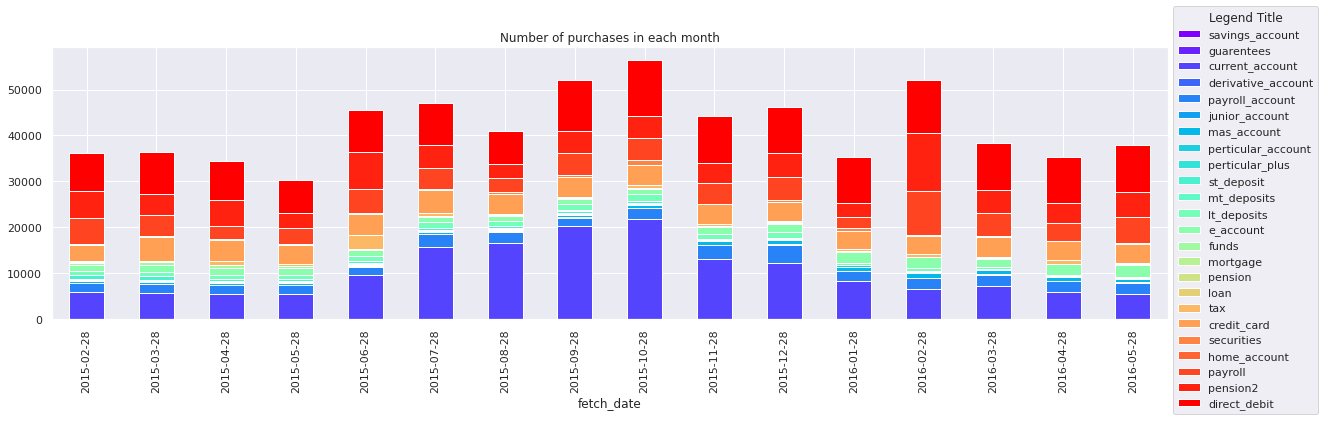

------------------------------------------------------------------------------------------------------------------------------------------------------


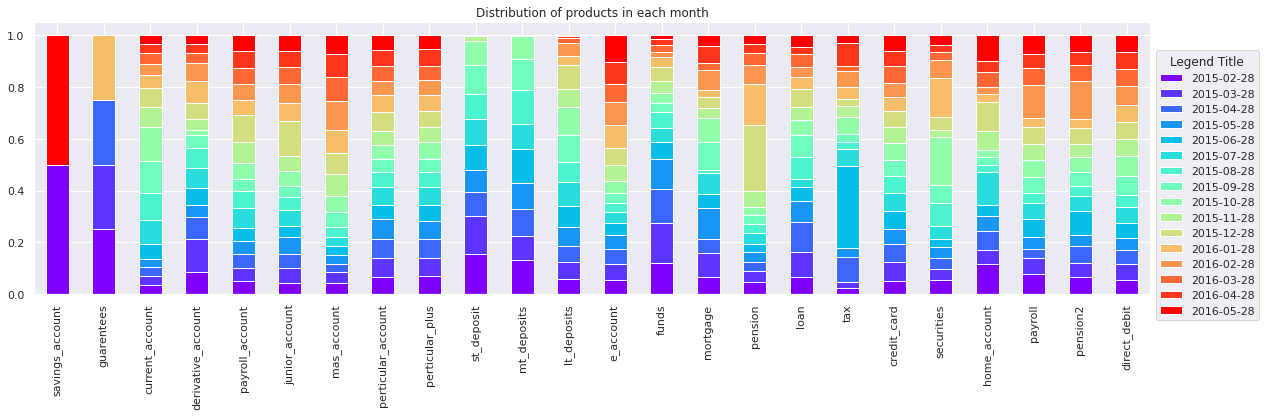

In [ ]:
#plotting number of purchases in each month
dummy = new_purchases[['fetch_date']+target_columns].groupby('fetch_date').sum()
dummy.plot(kind='bar',stacked=True, colormap='rainbow',figsize=(20,5))
plt.legend(loc='center left', title='Legend Title', bbox_to_anchor=(1, .4))
plt.title('Number of purchases in each month')
plt.show()
print('-'*150)
#Plotting the distribution of products in each month
dummy = new_purchases[['fetch_date']+target_columns].groupby('fetch_date').sum()
dummy = dummy/dummy.sum()
dummy = dummy.T
dummy.plot(kind='bar',stacked=True, colormap='rainbow',figsize=(20,5))
plt.legend(loc='center left', title='Legend Title', bbox_to_anchor=(1, .4))
plt.title('Distribution of products in each month')
plt.show()

Observation:
1. We can see observe some purchase trends in this chart.
2. There are only few purchases for savings account and guarentees.
3. Products which have more blue shades like short term deposits(st_deposits).and mid term term deposits were bought in 2015, and their popularity went on to decrease in 2016.
4. Tax account was created the most in the time of october.
5. Pension account was created the most in the month of december.
6. products like funds and long term deposits have lost their popularity over the time.

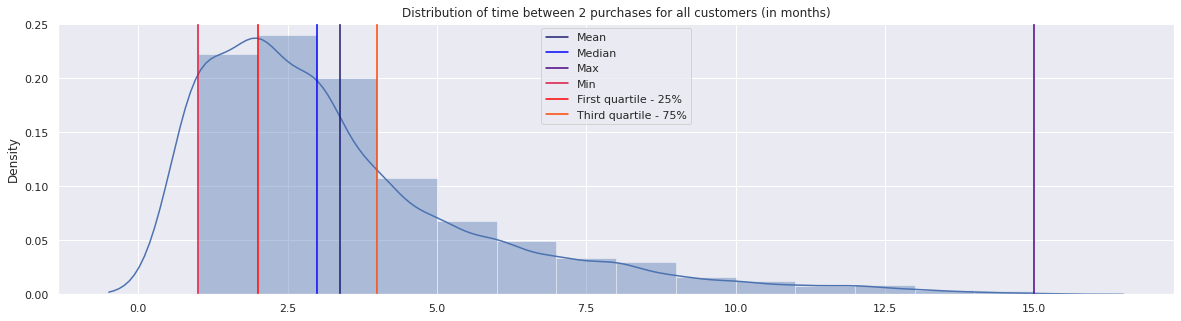


 On an average a person buys a product every 3 Months


In [ ]:
#Plotting the distribution of time between 2 successive purchases
dummy = new_purchases.copy()

dummy = new_purchases[new_purchases[target_columns].sum(axis=1)>0]
dummy = dummy.sort_values(['cust_code', 'fetch_date'])
dates = new_purchases.fetch_date.unique()
dates.sort()
d = dict(zip(dates, range(dates.shape[0])))
dummy['month'] = dummy.fetch_date.map(d)

dummy = dummy[['cust_code', 'month']][1:] - dummy[['cust_code', 'month']].shift(1)[1:]  #Get the difference 
dummy = dummy[dummy.cust_code == 0] #Remove all the records where difference between cust codes is not zero as it would be of different customers

#Plot distribution
plt_title = 'Distribution of time between 2 purchases for all customers (in months)'
plot_distribution(dummy.month, plt_title, figsize=(20,5))
print('\n On an average a person buys a product every {} Months'.format(int(dummy.month.median())))

### Analyzing emp_index

Employee index: A active, B ex employed, F filial, N not employee, P pasive (Filial means son/daughter but if see the data those customers are older than 30 years, So we can't say anything about this as of now)

This feature is not unique for each transaction but is unique for each customer. So lets analyze the data keeping only one row for each customer

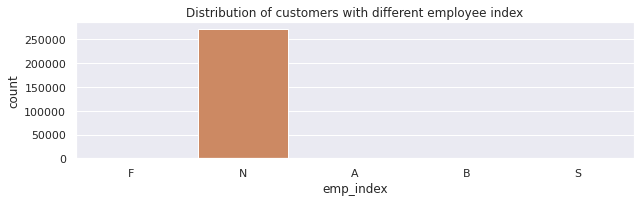


Distribution of customers with different employee index
F:69  N:271933  A:102  B:84  nan:623  S:1

 percentage of unemployed customers is 1.00


In [ ]:
#Plotting the distribution of customers based on their emp_index
title = 'Distribution of customers with different employee index'
allplots(data = user_features.emp_index, title = title, kind='countplot', figsize=(10,2.5))
counts = print_count(user_features.emp_index, title)
print('\n percentage of unemployed customers is {:.2f}'.format(counts['N']/len(user_features)))

#### Analyzing country of customer


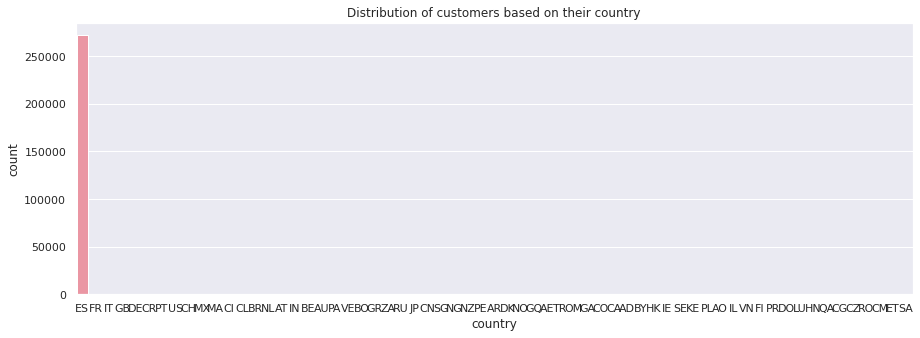


Distribution of customers based on their country
ES:271662  CR:1   CI:2   BE:17  ZA:2  NZ:1   AE:3   AD:3  PL:5  DO:1  RO:1
FR:37      PT:12  CL:7   AU:5   RU:4  PE:6   TR:2   BY:1  AO:2  LU:2  CM:1
IT:17      US:36  BR:13  PA:2   JP:5  AR:30  OM:2   HK:1  IL:1  HN:1  ET:1
GB:65      CH:49  NL:10  VE:25  CN:4  DK:3   GA:1   IE:7  VN:1  QA:2  SA:1
DE:59      MX:22  AT:6   BO:3   SG:4  NO:3   CO:10  SE:3  FI:3  CG:1
nan:623    MA:7   IN:1   GR:3   NG:1  GQ:3   CA:2   KE:1  PR:2  CZ:1

 percentage of native customers is 99.58


In [ ]:
#Plotting the distribution of customers based on their country
title = 'Distribution of customers based on their country'
allplots(data = user_features.country, title = title, kind='countplot', figsize=(15,5))
counts = print_count(user_features.country, title)
print('\n percentage of native customers is {:.2f}'.format(counts['ES'] *100/len(user_features)))

#### Analyzing sex

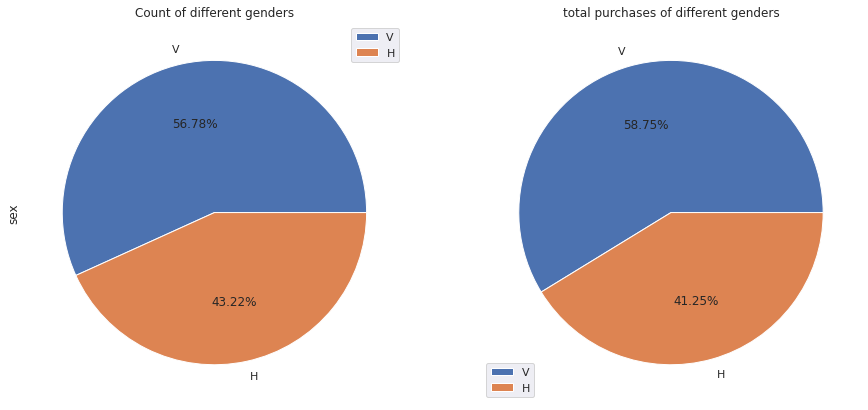

------------------------------------------------------------------------------------------------------------------------------------------------------


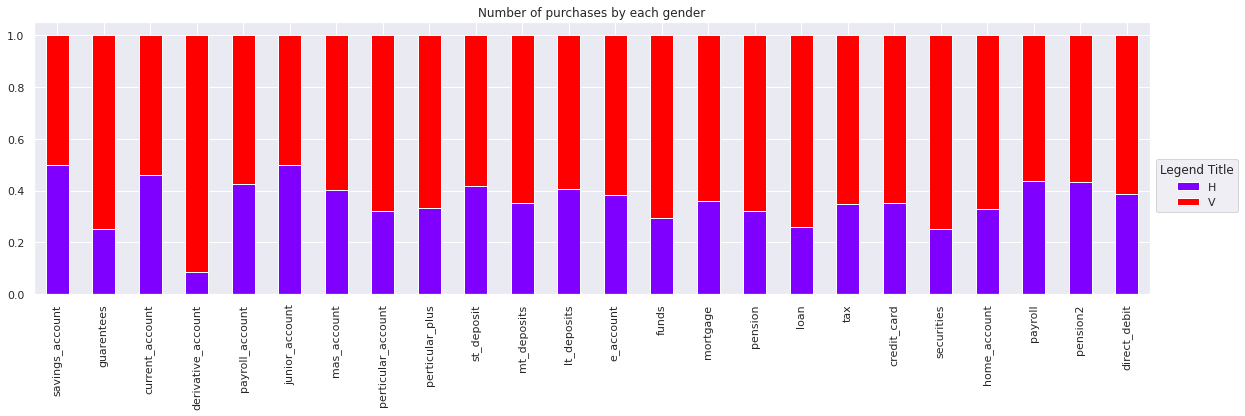

In [ ]:
#Plotting the distribution of customers based on their sex
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
title = 'Count of different genders'
allplots(data = user_features.sex, title = title, kind='piecountplot')
plt.subplot(1,2,2)
gender_purchases = user_features.groupby('sex').sum()[target_columns].sum(axis=1)
gender_purchases = dict(zip(gender_purchases.index[::-1], np.array(gender_purchases.values, dtype=int)[::-1]))
title = 'total purchases of different genders'
allplots(data = gender_purchases, title = title, kind='piepurchaseplot')
plt.show()
print('-'*150)

#Plotting the number of purchases by each gender
dummy = user_features.drop('cust_code', axis=1).groupby('sex')[target_columns].sum()
dummy = (dummy/dummy.sum()).T
dummy.plot(kind='bar',stacked=True, colormap='rainbow',figsize=(20,5))
plt.legend(loc='center left', title='Legend Title', bbox_to_anchor=(1, .4))
plt.title('Number of purchases by each gender')
plt.show()

Observation
1. We can see gender V constitutes to have bought more products on an average than gender H
2. We can see the gender distribution in derivative account is very skewed, Where only V gender has bought most of the products.
3. All the show almost same ration of gender participation and V gender is dominent in all product purchases

#### Analyzing age

In [ ]:
print('percentage of users who have their age missing is {:.2f}%'.format(len(user_features[user_features.age == ' NA']) * 100 / len(user_features)))
print('We will replace those with median value')
user_features.age[user_features.age == ' NA'] = np.median(np.array(user_features.age[user_features.age != ' NA'], dtype=int))
user_features.age = user_features.age.astype(int)

percentage of users who have their age missing is 0.24%
We will replace those with median value


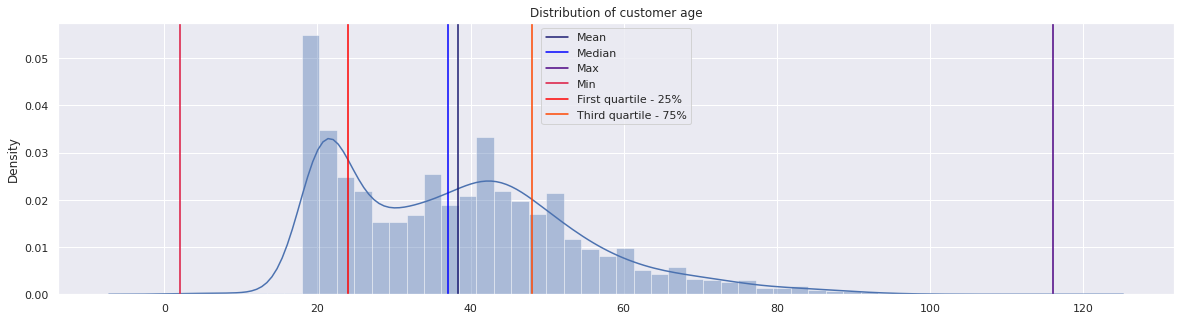

------------------------------------------------------------------------------------------------------------------------------------------------------


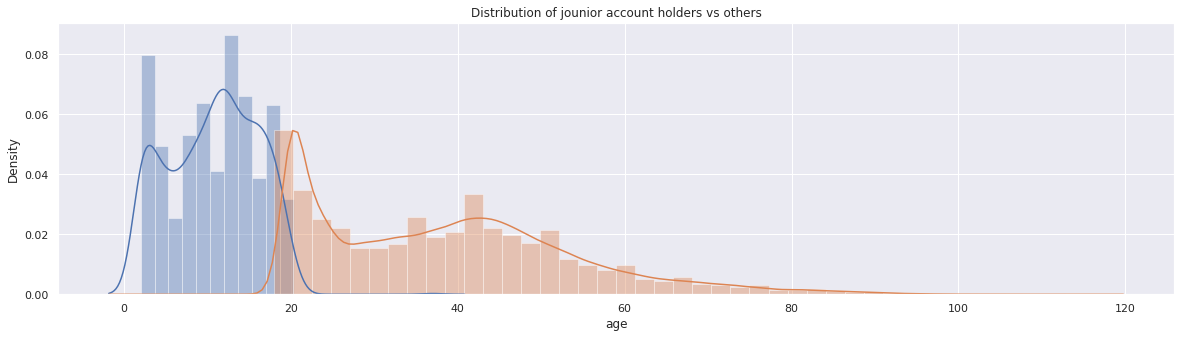

Among the customers aged below 20, 25.03% customers have bought jounior account
----------------------------------------------------------------------------------------------------


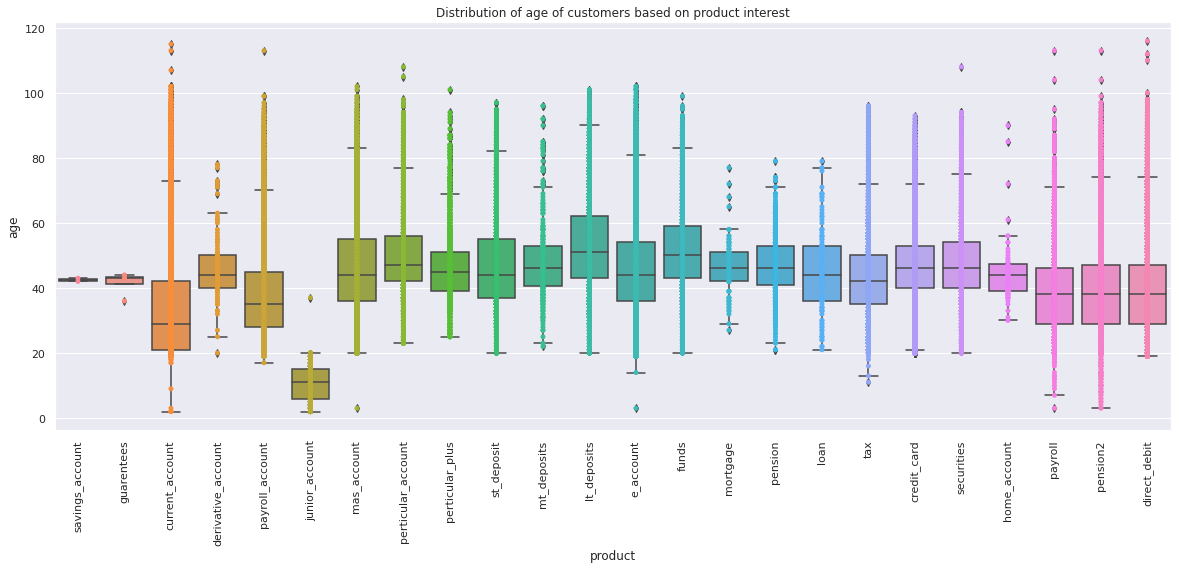

In [ ]:
#Plotting the distribution of age
plt_title = 'Distribution of customer age'
plot_distribution(user_features.age, plt_title, figsize=(20,5), bins=50)

print('-'*150)
#Compute a dummy pandas dataframe from dask dataframe (We can not perform group by or assign values to dask dataframe)
juniorage = user_features[user_features.junior_account > 0].age
#Compute a dummy pandas dataframe from dask dataframe (We can not perform group by or assign values to dask dataframe)
middlegaed = user_features[user_features.junior_account == 0].age

#Plottingg distribution of jounior account holders vs others
plt.figure(figsize=(20,5))
plt.title('Distribution of jounior account holders vs others')
sn.distplot(juniorage)
sn.distplot(middlegaed)
plt.show()
print('Among the customers aged below 20, {:.2f}% customers have bought jounior account'
      .format(100*len(user_features[(user_features.age<20) & (user_features.junior_account > 0)])/ len(user_features[(user_features.age<20)])))

print('-'*100)

dummy = pd.DataFrame(columns=['age', 'product'])
for col in target_columns:
  df = pd.DataFrame({'age':user_features.age[user_features[col] == 1],
                     'product':col})
  dummy = pd.concat([dummy, df])

#Plotting distribution of age of customers based on product interest
figsize=(20,7.5)
title = 'Distribution of age of customers based on product interest'
allplots(data = dummy, title = title, kind='stripplot', figsize=figsize)

Observations
1. We can see the distribution is bimodel. There are a large number of university aged students, and then another peak around middle-age.
2. We can see clear difference between the age group subscribing junior and and not
3. Median age for junior account is significantly less than others as expected.
4. Age can be a good feature as there is a lot difference in distribution of age of customers devided based on purchases

#### Analyzing new_cust

new customers means those who have joined the bank within last 6 months, the new_cust value changes to 0 for the same person who joined in the beginning of 2015 at the end of 2015.
Butas we have created user features dataset with first entry in the real dataset, new customer tag might be there on them who might be oldewr than 6 months.

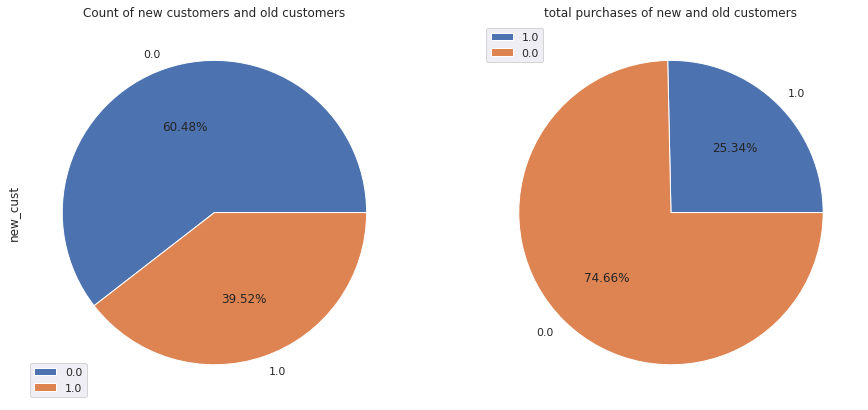

------------------------------------------------------------------------------------------------------------------------------------------------------


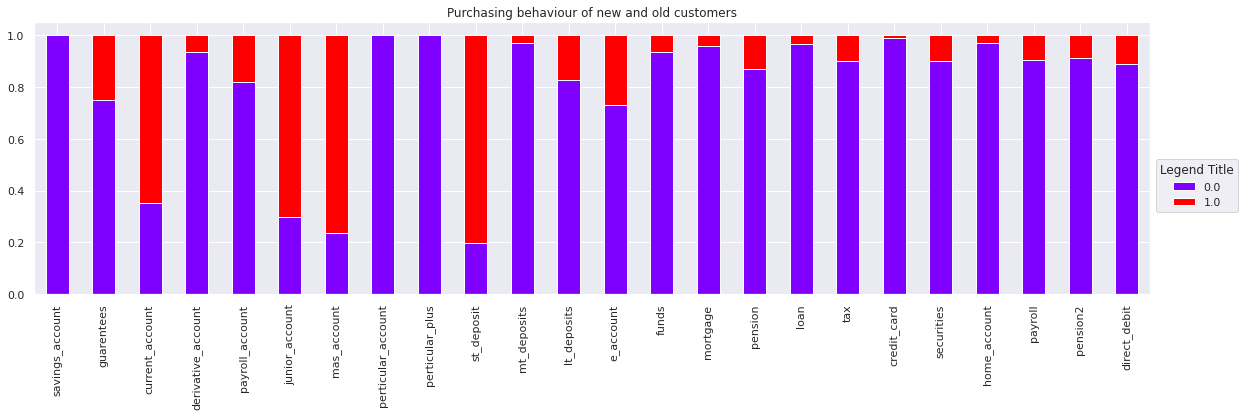

In [ ]:
#Plotting the distribution of new customers and old customers
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
title = 'Count of new customers and old customers'
allplots(data = user_features.new_cust, title = title, kind='piecountplot')
plt.subplot(1,2,2)
purchases = user_features.groupby('new_cust').sum()[target_columns].sum(axis=1)
purchases = dict(zip(purchases.index[::-1], np.array(purchases.values, dtype=int)[::-1]))
title = 'total purchases of new and old customers'
allplots(data = purchases, title = title, kind='piepurchaseplot')
plt.show()

print('-'*150)
#plotting the purchasing behaviour of new and old customers
dummy = user_features.drop('cust_code', axis=1).groupby('new_cust')[target_columns].sum()
dummy = (dummy/dummy.sum()).T
dummy.plot(kind='bar',stacked=True, colormap='rainbow',figsize=(20,5))
plt.legend(loc='center left', title='Legend Title', bbox_to_anchor=(1, .4))
plt.title('Purchasing behaviour of new and old customers')
plt.show()

Observations:
1. new customers are 39.52% in numbers but they have contributed only 25% of all purchases.
2. New customers purchase current account, juniour account, mas account, and short term deposits the most.
3. There are very few participation in all the other products by new customers.
4. New customers have not bought savings account, perticular account and perticular plus accounts

#### Analyzing cust_seniority

In [ ]:
print('percentage of users who have their cust_seniority missing is {:.2f}%'.format(len(user_features[user_features.cust_seniority == '     NA']) * 100 / len(user_features)))
print('We will replace those with median value')
user_features.cust_seniority[(user_features.cust_seniority == '     NA') | (user_features.cust_seniority == '-999999')] = np.median(np.array(user_features.age[user_features.cust_seniority != '     NA'], dtype=int))
user_features.cust_seniority = user_features.cust_seniority.astype(float)

percentage of users who have their cust_seniority missing is 0.24%
We will replace those with median value


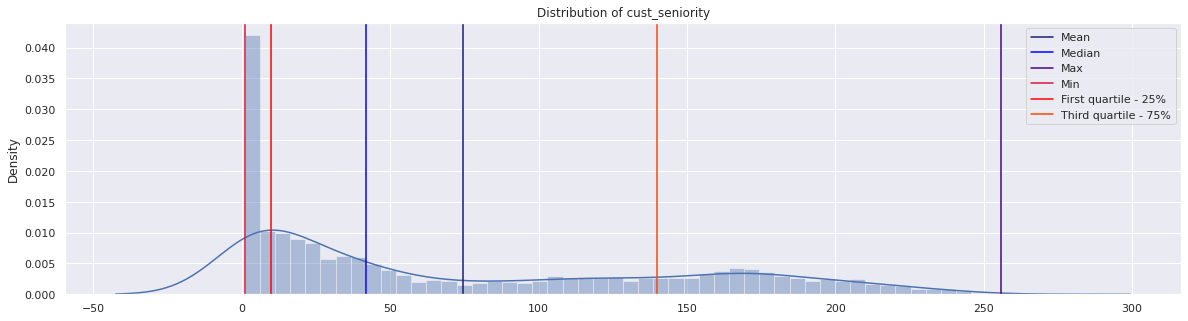

------------------------------------------------------------------------------------------------------------------------------------------------------


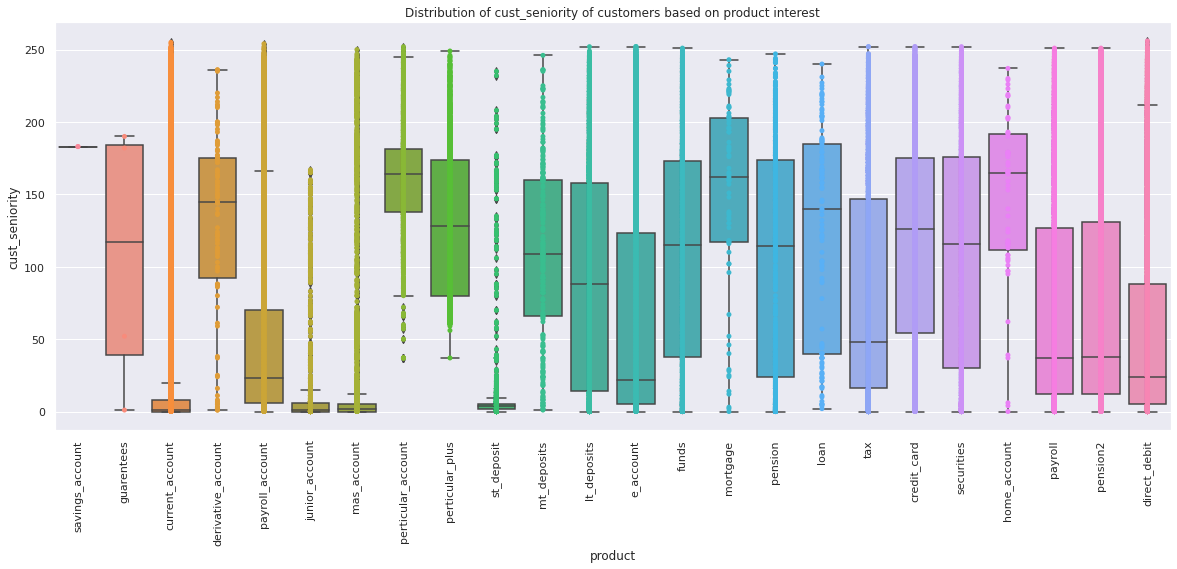

In [ ]:
#Plotting the distribution of cust_seniority
plt_title = 'Distribution of cust_seniority'
plot_distribution(user_features.cust_seniority[user_features.cust_seniority>0], plt_title, figsize=(20,5), bins=50)

print('-'*150)

dummy = pd.DataFrame(columns=['cust_seniority', 'product'])
for col in target_columns:
  df = pd.DataFrame({'cust_seniority':user_features.cust_seniority[user_features[col] == 1],
                     'product':col})
  dummy = pd.concat([dummy, df])

#Plotting distribution of age of customers based on product interest
figsize=(20,7.5)
title = 'Distribution of cust_seniority of customers based on product interest'
allplots(data = dummy, title = title, kind='stripplot', figsize=figsize)

Observations
1. We can see there are two modes formed.
2. The number of customers joined as increased in last 4 years.
3. Customers who bought current account, juniour account, mas account, short term account have bought them recently.
4. Oldest customers have bought mortgage and home accounts.

#### Analyzing indrel

1 (First/Primary), 99 (Primary customer during the month but not at the end of the month)

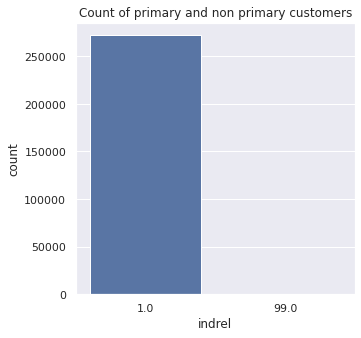


percentage of primary customers is 99.64%


In [ ]:
#Plotting the distribution of customers based on their emp_index
title = 'Count of primary and non primary customers'
allplots(data = user_features.indrel, title = title, kind='countplot', figsize=(5,5))
counts = print_count(user_features.indrel, title, show=False)
print('\npercentage of primary customers is {:.2f}%'.format(counts[1.0]*100/len(user_features)))

#### Analyzing cust_type

Customer type at the beginning of the month ,1 (First/Primary customer), 2 (co-owner ),P (Potential),3 (former primary), 4(former co-owner)

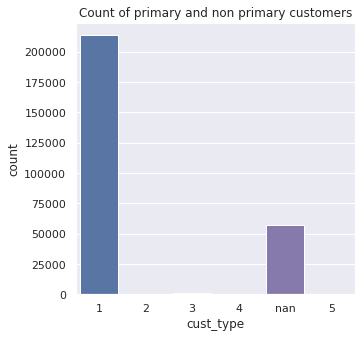


Count of primary and non primary customers
1:213315  2:423  3:1403  4:124  nan:57205  5:342

percentage of primary customers is 78.19%
percentage of missing values is 0.00%
------------------------------------------------------------------------------------------------------------------------------------------------------


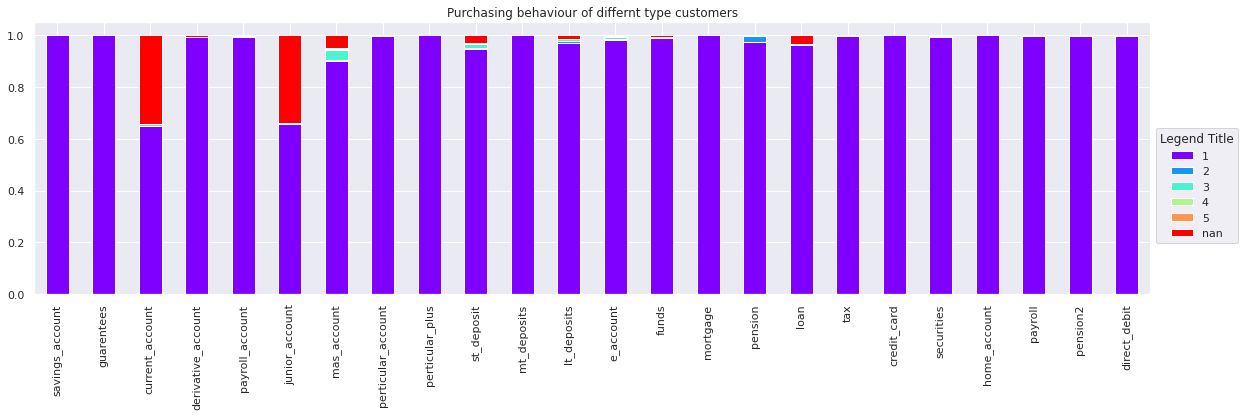

In [ ]:
#There are int decimal values for cust_type for same cust_types
user_features.cust_type[user_features.cust_type == 'P'] = '5'
user_features.cust_type[user_features.cust_type == '1.0'] = '1'
user_features.cust_type[user_features.cust_type == '2.0'] = '2'
user_features.cust_type[user_features.cust_type == '3.0'] = '3'
user_features.cust_type[user_features.cust_type == '4.0'] = '4'

#Plotting the distribution of customers based on their acount type
user_features.cust_type = user_features.cust_type.astype(str) 
title = 'Count of primary and non primary customers'
allplots(data = user_features.cust_type, title = title, kind='countplot', figsize=(5,5))
counts = print_count(user_features.cust_type, title)
print('\npercentage of primary customers is {:.2f}%'.format(counts['1']*100/len(user_features)))
print('percentage of missing values is {:.2f}%'.format(counts[np.nan]*100/len(user_features)))

print('-'*150)

#Plotting the purchasing behaviour of differnt type customers
dummy = user_features.drop('cust_code', axis=1).groupby('cust_type')[target_columns].sum()
dummy = (dummy/dummy.sum()).T
dummy.plot(kind='bar',stacked=True, colormap='rainbow',figsize=(20,5))
plt.legend(loc='center left', title='Legend Title', bbox_to_anchor=(1, .4))
plt.title('Purchasing behaviour of differnt type customers')
plt.show()

Observations:
1. Customers with type misssing have mostly bought current account and juniour account
2. Customers with type 3 have bought mas account and short term deposits the most
3. Customers with type 2 have bought pensions the most

#### Analyzing cust_rel

Customer relation type at the beginning of the month, A (active), I (inactive), P (former customer),R (Potential)

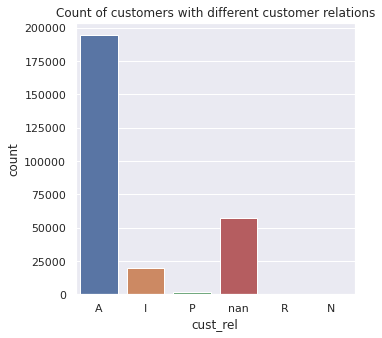


Count of customers with different customer relations
A:194099  I:19639  P:1527  nan:57205  R:340  N:2

percentage of active customers is 71.15%
percentage of missing values is 20.97%
------------------------------------------------------------------------------------------------------------------------------------------------------


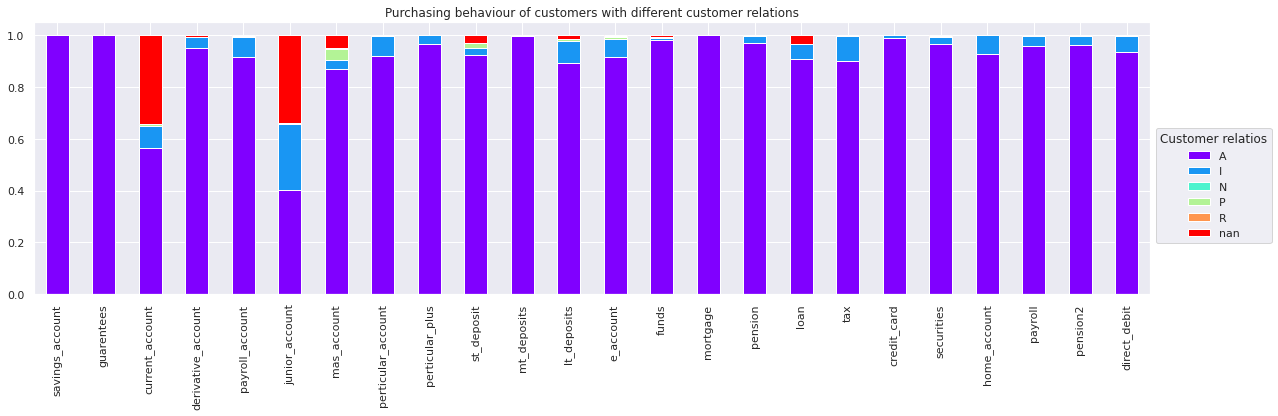

In [ ]:
##Plotting distribution of different types of customers
user_features.cust_rel = user_features.cust_rel.astype(str) 
title = 'Count of customers with different customer relations'
allplots(data = user_features.cust_rel, title = title, kind='countplot', figsize=(5,5))
counts = print_count(user_features.cust_rel, title)
print('\npercentage of active customers is {:.2f}%'.format(counts['A']*100/len(user_features)))
print('percentage of missing values is {:.2f}%'.format(counts['nan']*100/len(user_features)))

print('-'*150)

#plotting the purchasing behaviour of new and old customers
dummy = user_features.drop('cust_code', axis=1).groupby('cust_rel')[target_columns].sum()
dummy = (dummy/dummy.sum()).T
dummy.plot(kind='bar',stacked=True, colormap='rainbow',figsize=(20,5))
plt.legend(loc='center left', title='Customer relatios', bbox_to_anchor=(1, .4))
plt.title('Purchasing behaviour of customers with different customer relations')
plt.show()

Observations:

  1. Customers with relation misssing have mostly bought current account and juniour account
  2. Former customers have bought mas account and short term deposits the most
  3. Juniour acccount owners are from most diverse relations



#### Analyzing joining_channel

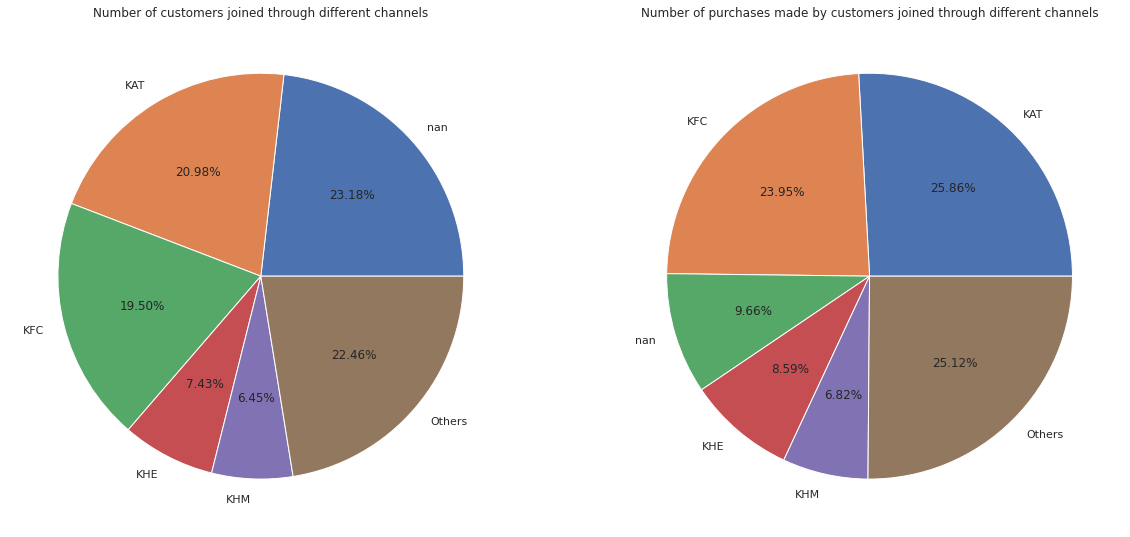

------------------------------------------------------------------------------------------------------------------------------------------------------


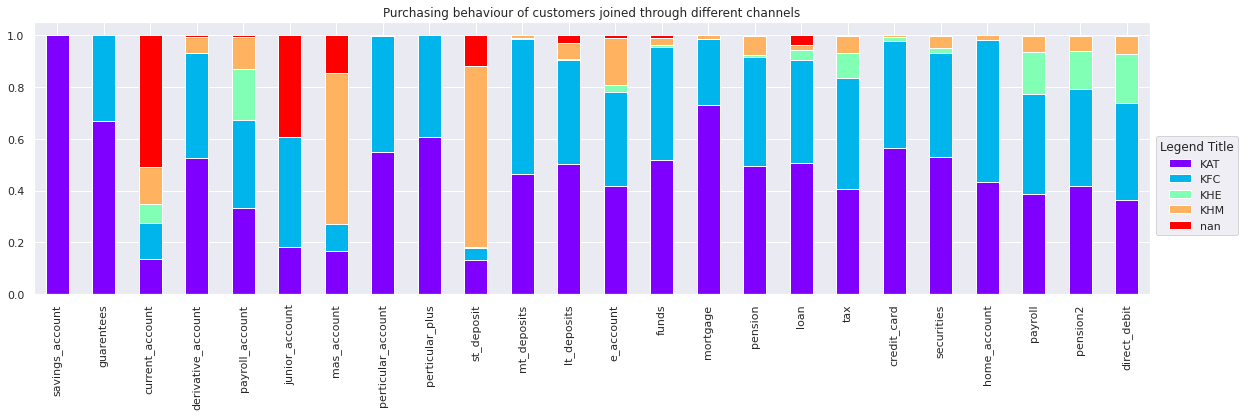

In [ ]:
##Plotting distribution of different joining_channels
user_features.joining_channel = user_features.joining_channel.astype(str)
value_counts = user_features.joining_channel.value_counts()
dummy = user_features.drop('cust_code', axis=1).groupby('joining_channel')[target_columns].sum().sum(axis=1)
dummy = dummy.sort_values(ascending=False)

plt.figure(figsize=(20,15))
plt.subplot(1,2,1)
plt.title('Number of customers joined through different channels')
plt.pie(list(value_counts.values[:5])+[value_counts.values[5:].sum()], labels = list(value_counts.index[:5])+['Others'], autopct='%1.2f%%')
plt.subplot(1,2,2)
plt.title('Number of purchases made by customers joined through different channels')
plt.pie(list(dummy.values[:5])+[dummy.values[5:].sum()], labels = list(dummy.index[:5])+['Others'], autopct='%1.2f%%')
plt.show()

print('-'*150)

#Plotting the urchasing behaviour of new and old customers
dummy = user_features.drop('cust_code', axis=1).groupby('joining_channel')[target_columns].sum()
dummy = dummy[dummy.index.isin(value_counts.keys()[:5])]
dummy = (dummy/dummy.sum()).T
dummy.plot(kind='bar',stacked=True, colormap='rainbow',figsize=(20,5))
plt.legend(loc='center left', title='Legend Title', bbox_to_anchor=(1, .4))
plt.title('Purchasing behaviour of customers joined through different channels')
plt.show()

1. Customers with joining channel missing are highest in the ratio but they have contributed to only 9% of totle purchases
2. Cusomers joined from KAT have made the most purchases
3. nan can be a useful feature as customers who bought only few products have nan
4. The customers who bought mas account and short term acccount are mostly from KHM Joining channel

#### Analyzing deceased

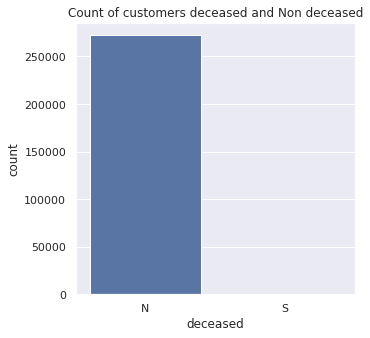


Count of customers deceased and Non deceased
N:272010  S:179  nan:623

 percentage of non deceased customers is 99.71%


In [ ]:
#Plotting the distribution of customers based on deceased
title = 'Count of customers deceased and Non deceased'
allplots(data = user_features.deceased, title = title, kind='countplot', figsize=(5,5))
counts = print_count(user_features.deceased, title)
print('\n percentage of non deceased customers is {:.2f}%'.format(counts['N']*100/len(user_features)))

####Analyzing prov_name

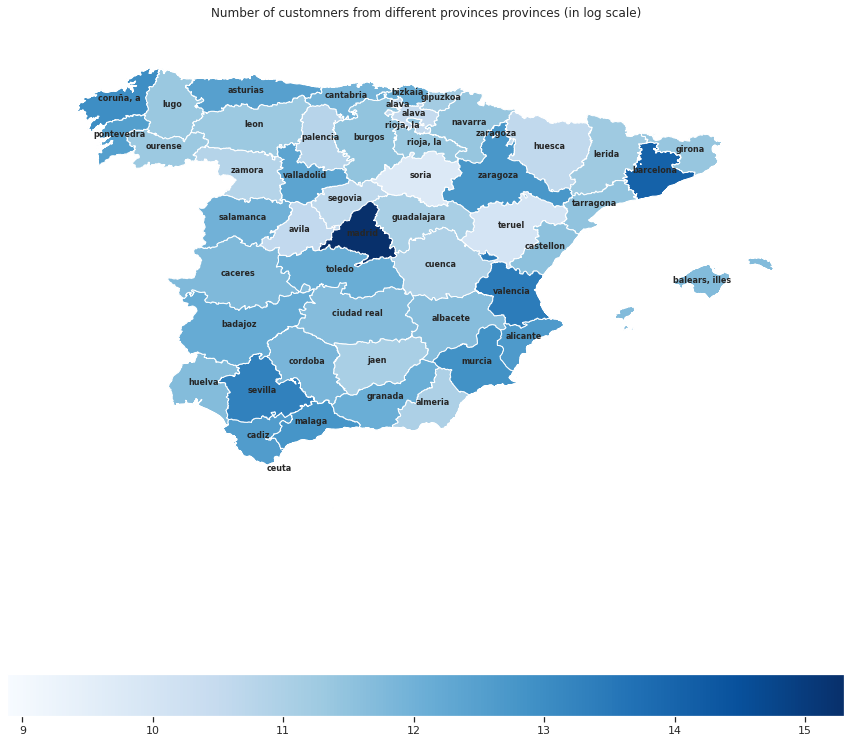

In [ ]:
#Gat the map dataframe of spain
map_df = gpd.read_file('/content/drive/MyDrive/Santander/Spain/Spain.shp')

#Get the centroid of each state
map_df['coords'] = map_df['geometry'].apply(lambda x: x.centroid.coords[:])
map_df['coords'] = [coords[0] for coords in map_df['coords']]

#Plotting the number of customers in each province
gplty.choropleth(map_df[~map_df.NAME_2.isin(['SANTA CRUZ DE TENERIFE', 'PALMAS, LAS', 'MELILLA'])], 
                hue = np.log(map_df.customers[~map_df.NAME_2.isin(['SANTA CRUZ DE TENERIFE', 'PALMAS, LAS','MELILLA'])]), 
                cmap = 'Blues', 
                figsize = (15,15), 
                legend=True,
                legend_kwargs={'orientation': 'horizontal'}
                )
plt.title('Number of customners from different provinces provinces (in log scale)')

for _, row in map_df[~map_df.NAME_2.isin(['SANTA CRUZ DE TENERIFE', 'PALMAS, LAS','MELILLA'])].iterrows():

  hue = round(row['customers'],2)
  
  plt.text(s=row['NAME_2'].lower(), x = row['coords'][0], y = row['coords'][1],
           horizontalalignment='center', fontdict = {'weight': 'bold', 'size': 8})

Observations:

1. We can see most of the users are from Madrid which is spains capital city
2. Other cities like Barcelona, Sevilla, Valencia follow Madrid.



#### Analyzing income (Gross income of the household)

In [ ]:
print('percentage of users who have their income missing is {:.2f}%'.format(len(user_features[user_features.income.isna()]) * 100 / len(user_features)))
print('We will exclude these from analysis')
print('highest recorded income is {}'.format(user_features.income.max()))

percentage of users who have their income missing is 34.29%
We will exclude these from analysis
highest recorded income is 28894395.51


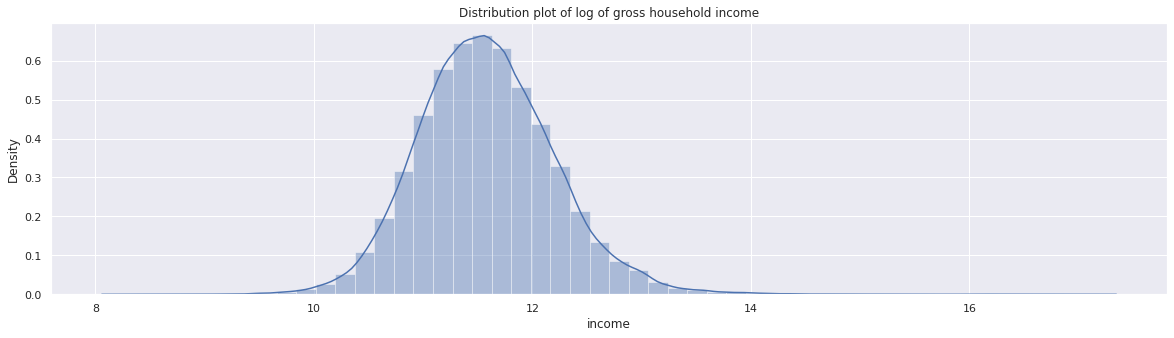

------------------------------------------------------------------------------------------------------------------------------------------------------


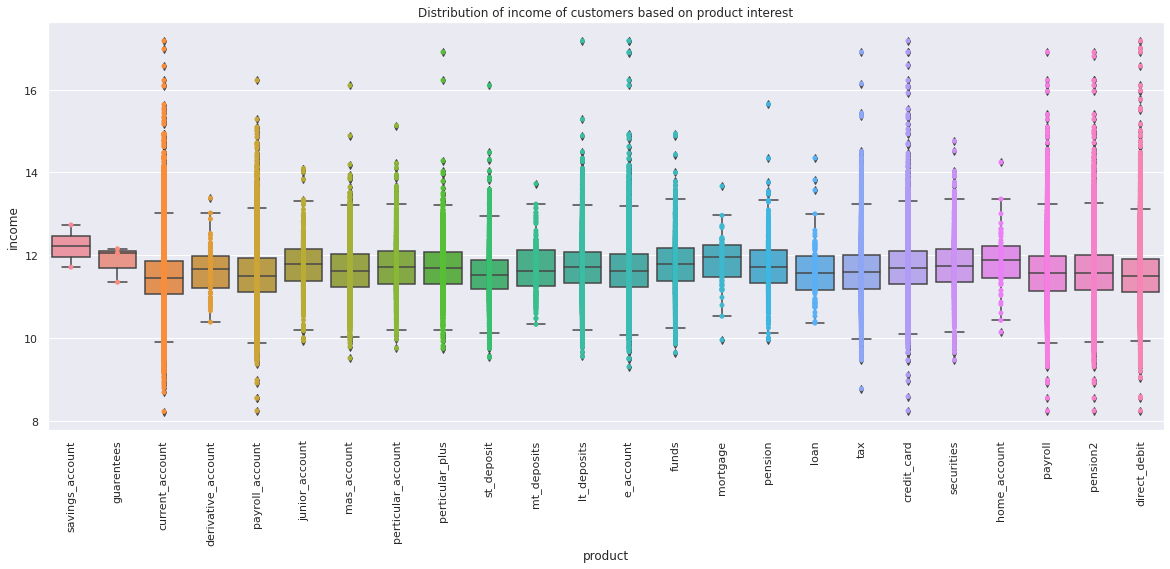

------------------------------------------------------------------------------------------------------------------------------------------------------


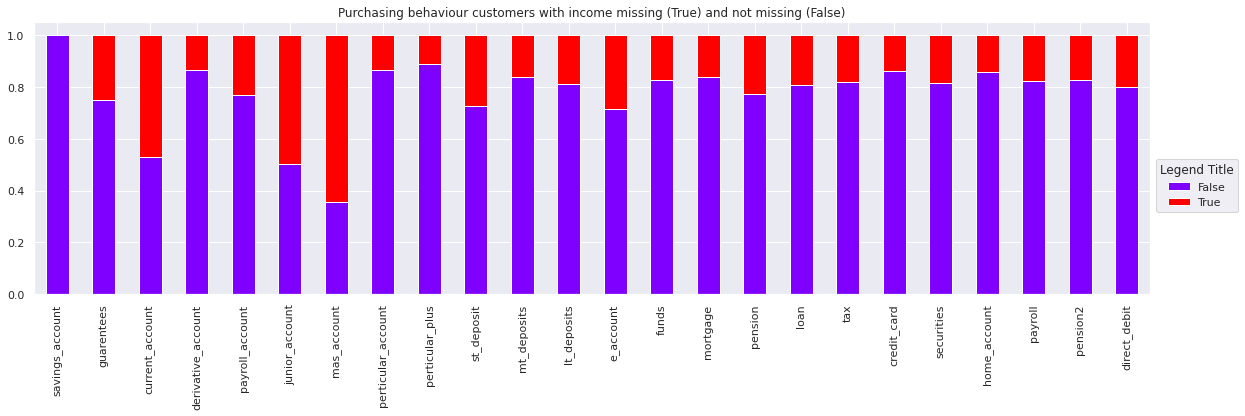

------------------------------------------------------------------------------------------------------------------------------------------------------


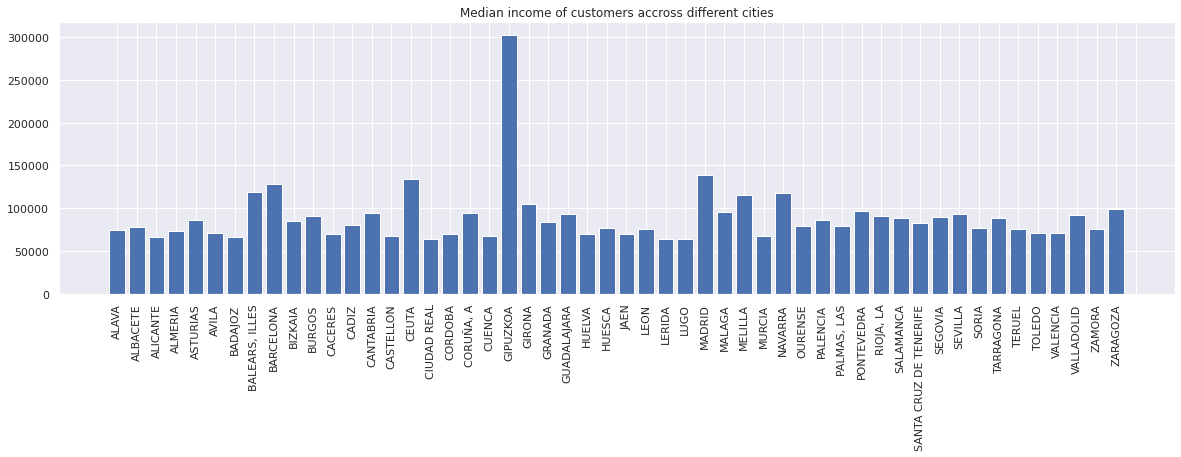

In [ ]:
#Plotting the distribution of income
plt.figure(figsize=(20,5))
plt.title('Distribution plot of log of gross household income')
sn.distplot(np.log(user_features.income[~user_features.income.isna()]))
plt.show()

print('-'*150)

dummy = pd.DataFrame(columns=['income', 'product'])
for col in target_columns:
  df = pd.DataFrame({'income':np.log(user_features.income[(user_features[col] == 1) & (~user_features.income.isna())]),
                     'product':col})
  dummy = pd.concat([dummy, df])

#Plotting distribution of income of customers based on product interest
figsize=(20,7.5)
title = 'Distribution of income of customers based on product interest'
allplots(data = dummy, title = title, kind='stripplot', figsize=figsize)

print('-'*150)

#Plotting the purchasing behaviour of new and old customers based on income missing or present
user_features['null_income'] = user_features.income.isna()
dummy = user_features.drop('cust_code', axis=1).groupby('null_income')[target_columns].sum()
dummy = (dummy/dummy.sum()).T
dummy.plot(kind='bar',stacked=True, colormap='rainbow',figsize=(20,5))
plt.legend(loc='center left', title='Legend Title', bbox_to_anchor=(1, .4))
plt.title('Purchasing behaviour customers with income missing (True) and not missing (False)')
plt.show()

print('-'*150)

#Plotting median income of customers accross different cities
dummy = user_features[['income', 'prov_name']].groupby('prov_name').median()
plt.figure(figsize=(20,5))
plt.bar(range(len(dummy)), dummy.income.values)
plt.title('Median income of customers accross different cities')
plt.xticks(np.arange(53),list(dummy.index), rotation = 90)
plt.show()

Observation:
1. Income follows log normal distribution
2. Median income of the customers of all the products is almost same
3. if income is missing, there is a higher probability that the customer would buy juniour account or mas account or current account
4. We can see gross house hold income of GIPUZKOA is the highest.

#### Analyzing segmentation (segmentation: 01 - VIP, 02 - Individuals 03 - college graduated)

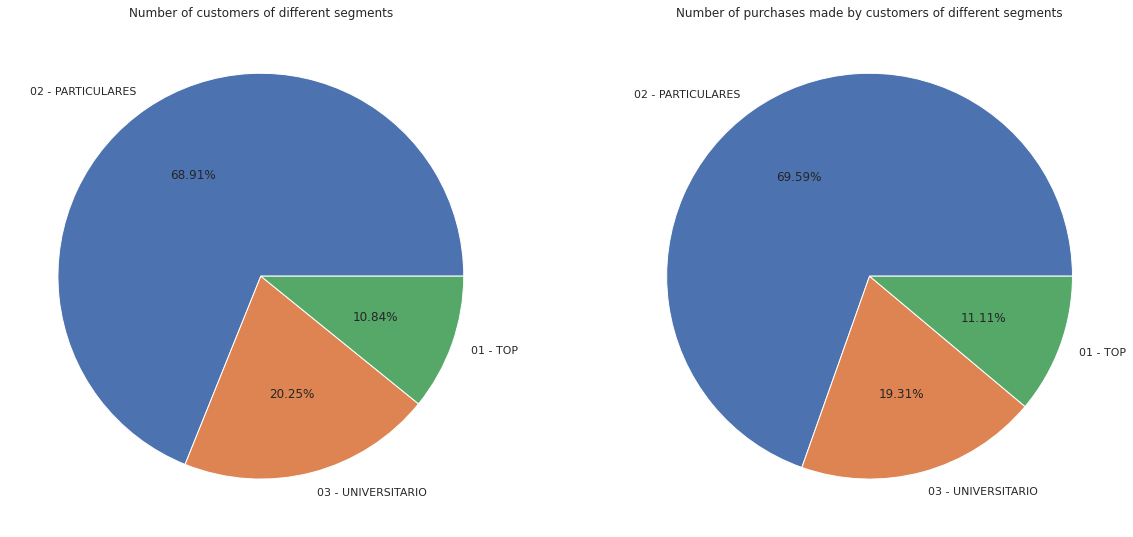

------------------------------------------------------------------------------------------------------------------------------------------------------


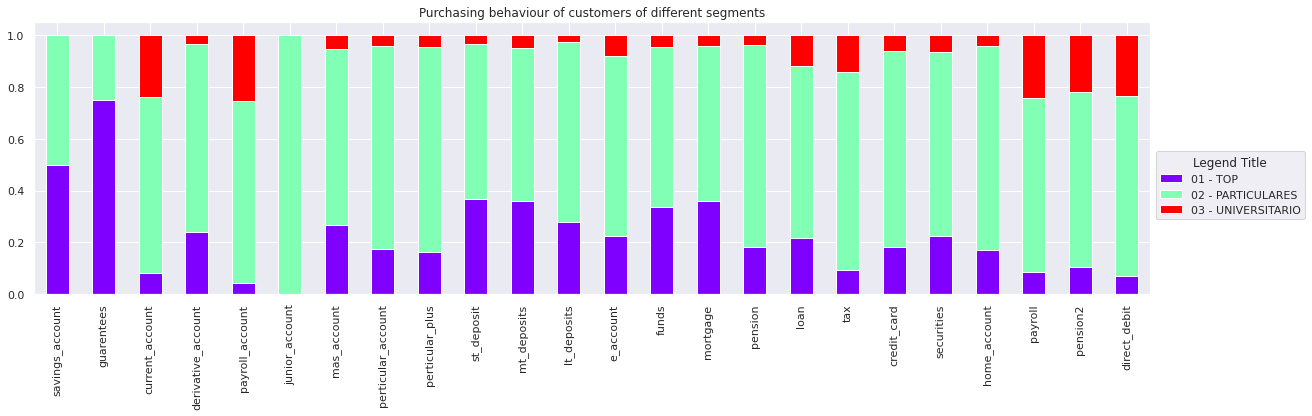

------------------------------------------------------------------------------------------------------------------------------------------------------


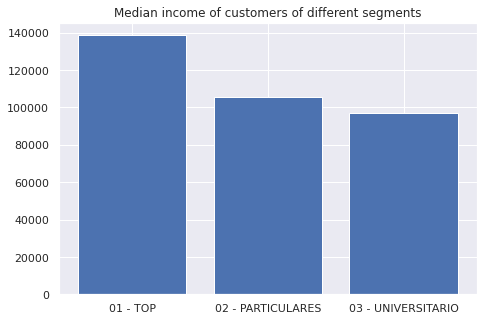

In [ ]:
#Plotting the distribution of customers based on their segmentation
plt.figure(figsize=(20,15))
plt.subplot(1,2,1)
value_counts = user_features.segmentation.value_counts()
value_counts = dict(zip(value_counts.index, np.array(value_counts.values, dtype=int)))
plt.title('Number of customers of different segments')
plt.pie(value_counts.values(), labels = value_counts.keys(), autopct='%1.2f%%')
plt.subplot(1,2,2)
purchases = user_features.groupby('segmentation').sum()[target_columns].sum(axis=1)
purchases = dict(zip(purchases.index, np.array(purchases.values, dtype=int)))
plt.title('Number of purchases made by customers of different segments')
plt.pie([purchases[x] for x in value_counts.keys()], labels= value_counts.keys(), autopct='%1.2f%%')
plt.show()

print('-'*150)

dummy = user_features.drop('cust_code', axis=1).groupby('segmentation')[target_columns].sum()
dummy = (dummy/dummy.sum()).T
dummy.plot(kind='bar',stacked=True, colormap='rainbow',figsize=(20,5))
plt.legend(loc='center left', title='Legend Title', bbox_to_anchor=(1, .4))
plt.title('Purchasing behaviour of customers of different segments')
plt.show()

print('-'*150)

#Plotting median income of customers of different segments
dummy = user_features[['income', 'segmentation']].groupby('segmentation').median()
plt.figure(figsize=(7.5,5))
plt.title('Median income of customers of different segments')
plt.bar(range(len(dummy)), dummy.income)
plt.xticks(np.arange(len(dummy)),list(dummy.index))
plt.show()

Observation:
1. We can see the count of segments is in correlation with the products the customers of that segments have bought
2. Type 2 is the most dominent segment of the customers
3. All the customers who have bought juniour account belong to segment 02
4. Customers of segment 01 have the highest average income and 03 have the least

#### Analyzing target features

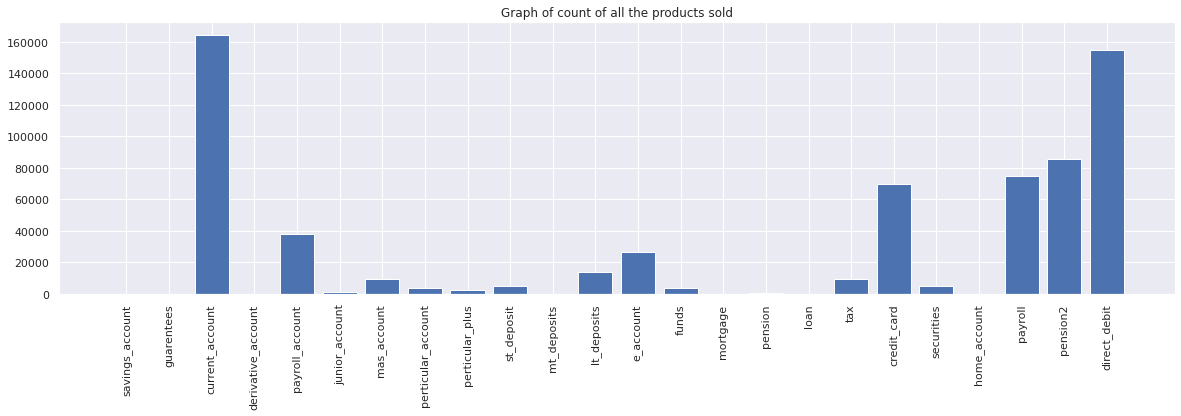

In [ ]:
#Plotting graph of count of all the products sold
plt.figure(figsize=(20,5))
plt.title('Graph of count of all the products sold')
plt.bar(range(len(target_columns)), user_features[target_columns].sum())
plt.xticks(np.arange(len(target_columns)),list(target_columns))
plt.xticks(rotation = 90)
plt.show()

observations:
1. current account, payroll, pension2 and direct debit are the most popular account.
2. savings account, guarentees, derivative account, morgage, pension, loan, home account are the least purchased products

### Solving the Problem

In [ ]:
#importing the required libraries
import csv
from scipy.sparse import csr_matrix, vstack, hstack
import numpy as np
import pandas as pd
from tqdm import tqdm
from time import time
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB
from scipy import stats
import optuna
from sklearn.metrics import precision_score, confusion_matrix
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from prettytable import PrettyTable

In [ ]:
#Pretty table is used to document the training process
table = PrettyTable()
table.field_names = ["Model", 'features', 'number of features', 'Score']

In [ ]:
#location of the datasets
train_data_loc = '/content/drive/MyDrive/Santander/train_ver2.csv'
test_data_loc = '/content/drive/MyDrive/Santander/test_ver2.csv'

#### Baseline Model

In [ ]:
#All the months for which the data is present
months = ['2015-01-28', '2015-02-28', '2015-03-28', '2015-04-28', '2015-05-28',
  '2015-06-28', '2015-07-28', '2015-08-28', '2015-09-28',
  '2015-10-28', '2015-11-28', '2015-12-28', '2016-01-28',
  '2016-02-28', '2016-03-28', '2016-04-28', '2016-05-28', '2016-06-28']
#Dictionary to map each month with a serial number
month_dict = dict(zip(months, np.arange(len(months))))

#Array of target columns
target_cols = np.array(['ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1',
                       'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1',
                       'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1',
                       'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
                       'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1',
                       'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
                       'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1',
                       'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1'])

#List of all the categorical columns
cat_columns = ['ind_empleado', 'sexo', 'ind_nuevo', 'indrel', 'indrel_1mes', 'tiprel_1mes', 'indresi', 'indext',
                'indfall', 'tipodom', 'ind_actividad_cliente', 'segmento', 'pais_residencia', 'canal_entrada']
num_columns = ['age', 'renta', 'antiguedad'] #List of all numerical columns

We know user can not buy a product which he already owns. So lets recommend a random products which the user dosen't own.

In [ ]:
def get_purchased_products(train_data_file, target_cols):
  '''
  This function takes data location and list of target column names
  Returns the products won by all the users

  train_data_file : Location of the csv file
  target_cols : List of target columns
  '''
  train_data_file = csv.DictReader(open(train_data_loc))

  purchased_products = {} #Dictionary to collect the products won by all the customers
  for row in tqdm(train_data_file):
    y = []
    for col in target_cols:
      c = row[col]
      if c and c != 'NA': # We append 0 if the value is missing or its 'NA'
        y.append(int(c))
      else:
        y.append(0)
    purchased_products[int(row['ncodpers'])] = y
  
  return purchased_products

def training_base_model(train_data_loc, test_data_loc, month_dict = month_dict, target_cols = target_cols):
  '''
  This function takes location of train and test data, month dictionary and array of target columns
  Returns the baseline prediction (Recomendation of a random product the customer doesnt own)

  train_data_loc : Location of training data
  test_data_loc : Location of testing data
  month_dict : month dict
  target_cols :  array of target column names
  '''

  train_data_file = csv.DictReader(open(train_data_loc)) #Reading the training file
  test_data_file = csv.DictReader(open(test_data_loc)) #Reading the test file

  no_of_products = 24
  test_data_len = len([1 for row in test_data_file])
  print('length of test data = ', test_data_len)
  t = time()
  print('getting model predictions..')
  pred = np.random.rand(test_data_len, 24) #Making arandom prediction
  pred = pred/pred.sum(axis=1)[:,None]
  print('prediction completed in {:2f} seconds'.format(time()-t))
  print('getting already purchased products..')
  purchased_products = get_purchased_products(train_data_file, target_cols = target_cols) 
  print('getting final produts')
  for r, row in enumerate(test_data_file): 
    prev_purchase = purchased_products.get(int(row['ncodpers']), [0]*24)
    for n in no_of_products:
      pred[r][n] = pred[r][n] - prev_purchase[n] #if the product is purchased already this would make the probaility <0

  pred = np.argsort(np.array(pred), axis=1) #Argsorting the prediction 
  pred = np.fliplr(pred)[:,:7] #Selecting the top 7 products
  print('returning the recommendable product ids')
  return pred

def productids_names(pred, target_cols):
  '''
  This function takes the prediction and target columns 
  returns a string with names of predicted products

  pred : Array of predctions
  target_cols : Array of target columns
  '''
  print('Converting product ids to names')
  return [" ".join(list(target_cols[p])) for p in pred]

def get_recomendations(recommendations, test_data_loc, filename):
  '''
  This function takes recomendation, test data location and file name 
  creates a csv file in the submission file format

  recommendations : list of recomendations
  test_data_loc : location of test data
  filename : Name of the submission file
  '''
  test_data_file = csv.DictReader(open(test_data_loc)) #Reading the test data
  test_ids = np.array([int(row['ncodpers']) for row in test_data_file]) #Get the user ids of customers in test data
  fields = ['ncodpers', 'added_products'] #Column names
  rows = np.vstack((test_ids, np.array(recommendations))).T #Creating an array of test ids and recomendations

  with open(filename, 'w') as csvfile: #Creating a csv file with given name
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(fields) #Writing column names tothe file
    csvwriter.writerows(rows) #Writing the rows to the file

  print(filename, 'is created')

In [ ]:
recommendations = training_base_model(train_data_loc, test_data_loc, month_dict = month_dict, target_cols = target_cols)
recommendations = productids_names(recommendations, target_cols)
get_recomendations(recommendations, test_data_loc, 'baseline.csv')
!kaggle competitions submit -c santander-product-recommendation -f /content/baseline.csv -m "baseline.csv"

length of test data =  929615
getting model predictions..
prediction completed in 0.242165 seconds
getting already purchased products..


13647309it [04:18, 52808.20it/s]


getting final produts
returning the recommendable product ids
Converting product ids to names
baseline.csv is created
100% 117M/117M [00:04<00:00, 26.1MB/s]
Successfully submitted to Santander Product Recommendation

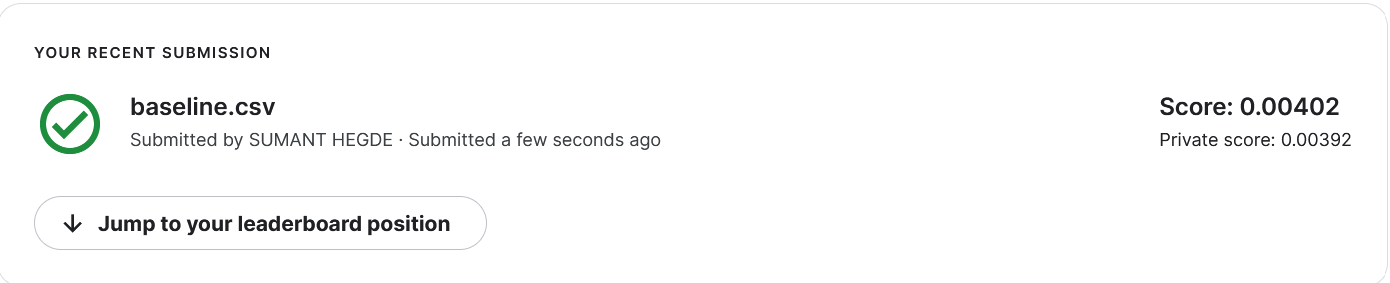

In [ ]:
table.add_row(['baseline (Random Prediction)', '', '', '0.00392'])

#### Baseline II
Recommending most famous products that's not already own

In [ ]:
def get_products_counts(train_data_loc, month_dict):
  '''
  This function takes train data location and month dictionary
  Return the count of products won by all the users in the month of June of the previous year

  train_data_loc : Location of training data
  month_dict : month dict
  '''
  train_data_file = csv.DictReader(open(train_data_loc)) #Reading the test data

  products_counts = [0]*24
  for row in tqdm(train_data_file):
    if month_dict[row['fecha_dato']] in [5]: #The purchase pattern of june 2015 and 2016 are similar(Got the hightest score on using the data)
      for c, col in enumerate(target_cols):
        if row[col] and row[col] != 'NA': 
          products_counts[c] += int(row[col]) #Increases the count of the product if its purchased
  return products_counts

def training_base_modelII(train_data_loc, test_data_loc, month_dict = month_dict, target_cols = target_cols):
  '''
  This function takes tran data location test data location, month_dict, target columns
  returns the recommendation of the most popular products

  train_data_loc : Location of training data
  test_data_loc : Location of testing data
  month_dict : month dict
  target_cols :  array of target column names
  '''

  train_data_file = csv.DictReader(open(train_data_loc)) #Reading the training file
  test_data_file = csv.DictReader(open(test_data_loc)) #Reading the test file

  no_of_products = 24
  test_data_len = len([1 for row in test_data_file])
  print('length of test data = ', test_data_len)
  print('processing training data..')
  products_counts = get_products_counts(train_data_loc, month_dict)
  print('getting model predictions..')
  pred = np.array([products_counts]*test_data_len)
  pred = pred/pred.sum(axis=1)[:,None] 
  print('getting already purchased products..')
  purchased_products = get_purchased_products(train_data_file, target_cols = target_cols)
  print('getting final produts')
  for r, row in enumerate(test_data_file):
    prev_purchase = purchased_products.get(int(row['ncodpers']), [0]*24)
    for n in no_of_products:
      pred[r][n] = pred[r][n] - prev_purchase[n] #if the product is purchased already this would make the probaility <0

  pred = np.argsort(np.array(pred), axis=1) #Argsorting the prediction 
  pred = np.fliplr(pred)[:,:7] #Selecting the top 7 products
  print('returning the recommendable product ids')
  return pred

recommendations = training_base_modelII(train_data_loc, test_data_loc, month_dict = month_dict, target_cols = target_cols)
recommendations = productids_names(recommendations, target_cols)
get_recomendations(recommendations, test_data_loc, 'baselineII.csv')
!kaggle competitions submit -c santander-product-recommendation -f /content/baselineII.csv -m "baselineII.csv"

length of test data =  929615
processing training data..


13647309it [02:50, 80125.25it/s]


getting model predictions..
getting already purchased products..


13647309it [06:38, 34251.23it/s]


getting final produts
returning the recommendable product ids
Converting product ids to names
baselineII.csv is created
100% 114M/114M [00:06<00:00, 17.4MB/s]
Successfully submitted to Santander Product Recommendation

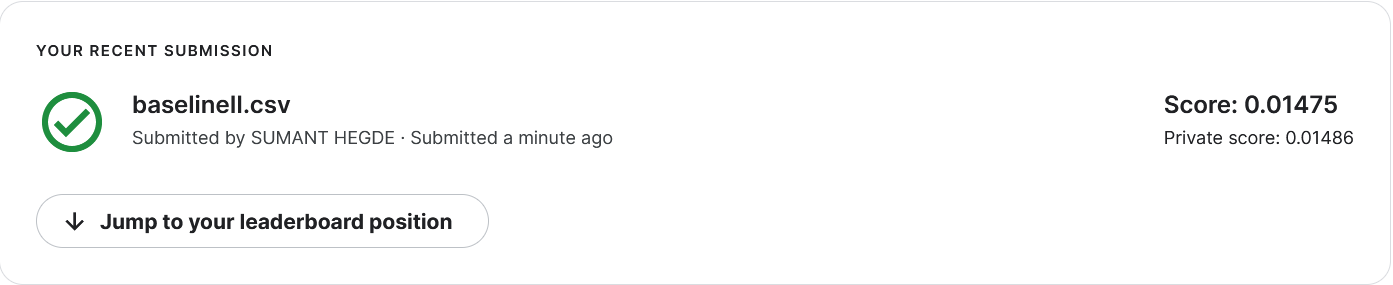

In [ ]:
table.add_row(['baselineII (Most famous products)', 'Past purchase count', '24', '0.01486'])

#### Naive Bayes

In [ ]:
def process_cat_columns(data, col, train, doc):
  '''
  This function takes the value, column name, if its for training and a document to hold the value and its id (Encoding)
  Return the id corresponding to the value for that column (It does Label Encoding)
  returns 999 for all the new values that is absent in training data

  data : Value
  col : column name
  train : if its for training or testing
  doc : dictionary that holds value and its encoding
  '''
  data = data.strip() #This strips leading or tailing spaces
  if train: #If data is for training
    if data and data != 'NA': #If data is not null
      if data not in doc[col].keys(): #if data is not present in doc
        doc[col][data] = len(doc[col]) #Len(doc[col]) will always be one more than the maximum encoding already set
      return doc[col][data] #Returning the encoding
    else: #If the data is null
      if 'nan' not in doc[col].keys(): #if 'nan' is absent in doc
        doc[col]['nan'] = len(doc[col]) #Len(doc[col]) will always be one more than the maximum encoding already set
      return doc[col]['nan'] #Returning the encoding for nan
  else: #If data is not for training
    if data and data != 'NA': #If data is not null
      if data not in doc[col].keys(): #if data is not present in doc
        return 999 
      return doc[col][data] #if data is present in doc return corresponding encoding
    else: #If the data is null
      if 'nan' not in doc[col].keys(): #if 'nan' is absent in doc
        return 999
      return doc[col]['nan'] #Returning the encoding for nan


def process_num_columns(data):
  '''
  This function takes numerical column values 
  returns float value of the data for the data present
  returns -9999.0 if value is null or in [' NA', '     NA', '-999999', '         NA', '-9999999999']
  '''
  if data and data not in [' NA', '     NA', '-999999', '         NA', '-9999999999']: #If data is not null 
    return float(data) 
  else: #If data is null 
    return -9999.0


def getMonth(row):
  '''
  This function takes a row (dictionary of data of a row in dataset) 
  Returns the month of that purchase (row)

  row: dictionary of data of a row in dataset
  '''
  return int(row['fecha_dato'].split('-')[1]) #Splits the date and returns the month

def numtobins(data_list):
  '''
  This takes numerical columns from train and test set
  returns binned columns

  data_list : list of train and test numerical columns
  '''
  processed_data = []
  for d, data in enumerate(data_list): #for train and test data
    if d == 0: #if its training data
      train_numerical = data[:,:3].toarray() #values by deafult in csr matrix converting them to np array
    x_var_numerical = data[:,:3].toarray()
    for i in range(3): #there are 3 numerical columns
      bins = np.percentile(train_numerical[:,i][train_numerical[:,i] != -9999.0], np.arange(10, 110, 10)) #bins are created with training data
      x_var_numerical[:,i][x_var_numerical[:,i] != -9999.0] = np.digitize(x_var_numerical[:,i][x_var_numerical[:,i] != -9999.0], bins=bins) #digitizing the training data
      x_var_numerical[:,i][x_var_numerical[:,i] == -9999.0] = 11 #If the value is null (-9999.0) we are setting to bin 11
    
    data = data[:,3:] #removing numerical columns from the data
    data = csr_matrix(hstack([csr_matrix(x_var_numerical), data])) #Stacking processed numerical columns on the data
    processed_data.append(data) #Keeping the data in processed_data list

  return processed_data #Returning the list of processed train and test data

def get_top_products(test_id, pred, test_prev_target, y_var):
  '''
  This function takes test_ids, prediction, previous target and training targets
  Returns top 7 recomendable products based on the prediction
  '''
  y_set = set(y_var) #Getting the set of all the targets in training dataset
  #pred = pred.toarray() #csr_array to np array
  for i, idx in tqdm(enumerate(test_id)): #For every test id
    for j, jdy in enumerate(y_set): #For every target in training target set
      if pred[i,j] <= test_prev_target[i][jdy]: #If the product is already purchased
        pred[i,j] = 0 #Set prediction to zero

  preds = np.argsort(pred, axis=1) #arg sorting the prediction
  preds = np.fliplr(preds)[:,:7] #selecting top 7 products

  return preds #Returning top 7 products

In [ ]:
def data_processing(data_loc, test_data_loc, trainmonths, lag_months, test_month):
  '''
  This function takes training and test data locations, Months to train on, lag months and the testing month

  returns the preprocessed train and test data in csr matrix form 

  data_loc : training data location 
  test_data_loc : test data location 
  trainmonths : Months to be trained on
  lag_months : Number of lag months
  test_month : Months to be tested on
  '''

  prev_target = {} #This holds the previous target of each user
  first_train_month = min(trainmonths) #This is the first month among the training months
  row_count, row_count_valid, row_count_test = 0, 0, 0 #Initializing the row counts
  matrix_row, matrix_col, matrix_data = [], [], [] #Initializing the train matrix
  matrix_row_valid, matrix_col_valid, matrix_data_valid = [], [], [] #Initializing the validation matrix
  matrix_row_test, matrix_col_test, matrix_data_test = [], [], [] #Initializing the test matrix
  y_var, y_var_valid = [],[] #initializing target variable of train and validation data
  previous_purchase_month = {} #This holds the month of previous purchase of each user
  test_prev_target = [] #This holds all the products each user holds at the end of training months
  test_id = [] #This holds the ids of test data
  lag = {} #This holds the purchase lag of each user each month
  doc = {} #This holds each category of each categorical feature and a unique int associated with it
  for col in cat_columns:
      doc[col] = {} #Initializing document for all the categorical columns
  
 
  data_file = open(data_loc) #opening the training file
  for row in tqdm(csv.DictReader(data_file)): #Reading the file
    if month_dict[row['fecha_dato']] == test_month:
      train = False #if its testing month keep train variable false
    else:
      train = True #if its training month keep train variable true

    if month_dict[row['fecha_dato']] >= first_train_month - lag_months: #If the month is in lag months of any training month
      y = [] #initializaing target variable for a row
      for col in target_cols: #processing the target cols (few target cols have str data)
        c = row[col]
        if c and c != 'NA':
          y.append(int(c))
        else:
          y.append(0)
      y = np.array(y)
      target = (y - prev_target.get(int(row['ncodpers']), np.zeros(24))) > 0 #target = product held this month - products held last month

      if target.sum() > 0: #if the customer has bought new product in the current month
        if month_dict[row['fecha_dato']] in trainmonths + [test_month]: #if the month in either training month or testing month
          col_count = 0 #initializing column count to zero
          
          row_cols = [] #initializing list to hold column numbers of current row
          row_values = [] #initializing list to hold values of columns of current row
          
          for col in num_columns: #for each numerical column
            v = process_num_columns(row[col]) #processing num columns
            if v != 0: #if value of col is non zero
              row_cols.append(col_count) #appending column number
              row_values.append(v) #appending col value
            col_count += 1 #moving to next column
          
          for col in cat_columns: #for each categorical column
            v = process_cat_columns(row[col], col, train, doc) #processing categorical columns
            if v != 0: #if value of col is non zero
              row_cols.append(col_count) #appending column number
              row_values.append(v) #appending col value
            col_count += 1 #moving to next column
          
          row_values.append(month_dict[row['fecha_dato']] % 12) #current month
          row_cols.append(col_count) #appending column number
          col_count += 1 #moving to next column

          row_values.append(month_dict[row['fecha_dato']] - previous_purchase_month.get(int(row['ncodpers']), 0)) #number months since last purchase
          row_cols.append(col_count) #appending column number
          col_count += 1 #moving to next column

          lag_columns = [] #initializing lag columns
          for i in range(1,lag_months+1): #for each lag month
            k = months[month_dict[row['fecha_dato']] - i] #lag month
            lg =  lag.get((int(row['ncodpers']), k), np.zeros(24)) #get the products held in lag month
            lag_columns += list(np.argwhere((lg)>0)[:,0]+ (i-1)*24 + col_count) #list products held in lag month

          row_cols += lag_columns #appending column numbers of lag columns
          row_values += [1]*len(lag_columns) #appending 1 for each lag column

          if train == True: #if its one of training month
            for ind, prod in enumerate(np.argwhere((target)>0)[:,0]): #columns where new product is purchased
              matrix_col += row_cols #appending all the columns numbers
              matrix_data += row_values #appending all the column values
              matrix_row += [row_count]*len(row_cols) #appending row counts
              y_var.append(prod) #appending target column
              row_count+=1 #increasing row count
          else: #if its one of validation month
            for ind, prod in enumerate(np.argwhere((target)>0)[:,0]): #columns where new product is purchased
              matrix_col_valid += row_cols #appending all the columns numbers
              matrix_data_valid += row_values #appending all the column values
              matrix_row_valid += [row_count_valid]*len(row_cols) #appending row counts
              y_var_valid.append(prod) #appending target column
              row_count_valid+=1 #increasing row count

      if target.sum() > 0: #if the customer has bought new product in the current month
        previous_purchase_month[int(row['ncodpers'])] = month_dict[row['fecha_dato']] #updating previous purchase month 
      prev_target[int(row['ncodpers'])] = list(y) #updating previous target
      lag[(int(row['ncodpers']), row['fecha_dato'])] = y #updating lag

  x_var = csr_matrix((matrix_data, (matrix_row,matrix_col))) #convering lists to csr matrix
  if test_month != 17: #if the test month is not june 2016
    x_var_test = csr_matrix((matrix_data_valid, (matrix_row_valid, matrix_col_valid))) #convering lists to csr matrix
  
  del matrix_data, matrix_row, matrix_col, matrix_data_valid, matrix_row_valid, matrix_col_valid #deleting lists from memory

  if test_month == 17: #if the test month is june 2016
    test_data_file = open(test_data_loc) #opening the testing file
    for row in tqdm(csv.DictReader(test_data_file)): #Reading the file

      test_id.append(int(row['ncodpers'])) #appending the customer id 
      col_count = 0 #initializing column count
      row_cols = [] #initializing list to hold column numbers of current row
      row_values = [] #initializing list to hold values of columns of current row

      for col in num_columns: #for each numerical column
        v = process_num_columns(row[col]) #processing num columns
        if v != 0: #if value of col is non zero
          row_cols.append(col_count) #appending column number
          row_values.append(v) #appending col value
        col_count += 1 #moving to next column
      
      for col in cat_columns: #for each categorical column
        v = process_cat_columns(row[col], col, False, doc) #processing categorical columns
        if v != 0: #if value of col is non zero
          row_cols.append(col_count) #appending column number
          row_values.append(v) #appending col value
        col_count += 1 #moving to next column

      row_values.append(month_dict[row['fecha_dato']] % 12) #current month
      row_cols.append(col_count) #appending column number
      col_count += 1 #moving to next column

      row_values.append(month_dict[row['fecha_dato']] - previous_purchase_month.get(int(row['ncodpers']), 0)) #number months since last purchase
      row_cols.append(col_count) #appending column number
      col_count += 1 #moving to next column

      lag_columns = [] #initializing lag columns
      for i in range(1,lag_months+1): #for each lag month
        k = months[month_dict[row['fecha_dato']] - i] #lag month
        lg =  lag.get((int(row['ncodpers']), k), np.zeros(24)) #get the products held in lag month
        lag_columns += list(np.argwhere((lg)>0)[:,0]+ (i-1)*24 + col_count) #list products held in lag month

      row_cols += lag_columns #appending column numbers of lag columns
      row_values += [1]*len(lag_columns) #appending 1 for each lag column
      
      matrix_col_test += row_cols #appending all the columns numbers
      matrix_data_test += row_values #appending all the columns values
      matrix_row_test += [row_count_test]*len(row_cols) #appending row counts
      row_count_test+=1 #increasing row count
      test_prev_target.append(prev_target.get(int(row['ncodpers']),np.zeros(24))) #getting the previously purchased products

    x_var_test = csr_matrix((matrix_data_test, (matrix_row_test, matrix_col_test))) #convering lists to csr matrix

  del matrix_data_test, matrix_row_test, matrix_col_test #deleting lists from memory

  return x_var, y_var, y_var_valid, x_var_test, test_prev_target, test_id, doc

In [ ]:
trainmonths = [6,7,8,9,10,11,12,13,14,15,16] #months of data to be trained on 
lag_months = 6 #Number of lag months to be used
test_month = 17 #testing month (June 2016)

print('Processing the data...')
processed_data = data_processing(train_data_loc, test_data_loc, trainmonths, lag_months, test_month)
x_var, y_var, y_var_valid, x_var_test, test_prev_target, test_id, doc = processed_data

#Converting numerical columns into bins
x_varb, x_var_testb = numtobins([x_var, x_var_test])
for i in range(x_varb.shape[1]): #for each column in training set
  if len(set(x_var_testb[:,i].toarray()[:,0]) - set(x_varb[:,i].toarray()[:,0])): #if the testing data contains unseen categories (value=999)
    a = x_var_testb[:,i].toarray() #Converting the colun to array
    a[a==999] = max(set(x_varb[:,i].toarray()[:,0]), key = list(x_varb[:,i].toarray()[:,0]).count) #assinging mode value to unseen category
    x_var_testb = csr_matrix(hstack([x_var_testb[:,:i], csr_matrix(a), x_var_testb[:,i+1:]])) #adding the processed column back to csr matrix

print('train data shape', x_varb.shape)
print('test data shape', x_var_testb.shape)
train_y = np.array(y_var)
y_set = set(train_y)

print('training the model...')
t = time()
cnb = CategoricalNB()
cnb.fit(x_varb.toarray(), train_y)
print('time taken to train the model', time()-t)

print('making the predictions...')
t = time()
pred = cnb.predict_proba(x_var_testb.toarray())
print('time taken to predict', time()-t)

print('Getting the recommendations')
recommendations = get_top_products(test_id, pred, test_prev_target, y_set) #get top products
recommendations = productids_names(recommendations, target_cols) #get product names
get_recomendations(recommendations, test_data_loc, 'categoricalNB.csv') #creating the submission file
!kaggle competitions submit -c santander-product-recommendation -f /content/categoricalNB.csv -m "categoricalNB"

Processing the data...


13647309it [14:24, 15784.91it/s]
929615it [01:55, 8040.36it/s]


train data shape (531717, 164)
test data shape (929615, 164)
training the model...
time taken to train the model 24.94024419784546
making the predictions...
time taken to predict 22.810994863510132
Getting the recommendations


929615it [00:26, 34972.20it/s]


Converting product ids to names
categoricalNB.csv is created
100% 116M/116M [00:03<00:00, 31.0MB/s]
Successfully submitted to Santander Product Recommendation

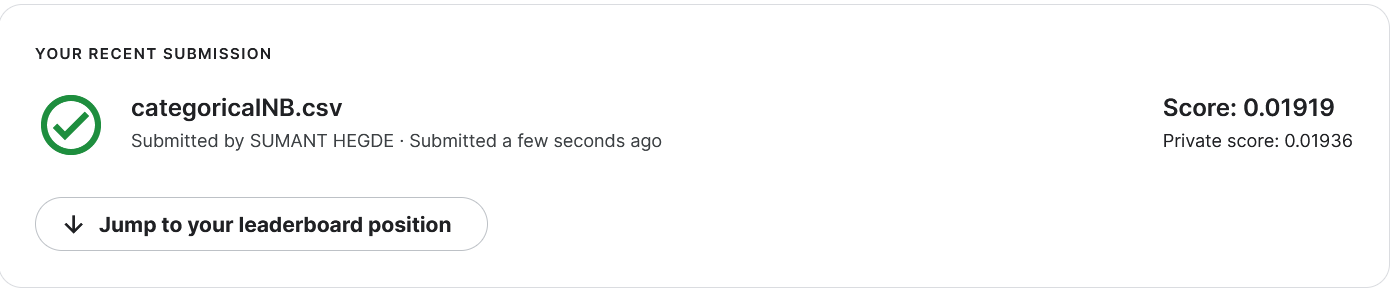

In [ ]:
table.add_row(['categorical NB', 'User features and Lags', '164', '0.01936'])

#### Tree Based models

In [ ]:
def alltreeclassifier(x_var, y_var, y_var_valid, x_var_test):
  '''
  This function takes train and test/validation data
  returns prediction of ensemble model of xgboost, lgbm and catboost models
  '''
  print('train data shape', x_var.shape)
  print('test data shape', x_var_test.shape)
  train_y = np.array(y_var)

  print('training the xgb model...')
  t = time()
  model = XGBClassifier(n_estimators=100)
  model.fit(x_var, train_y)
  print('time taken to train the model', time()-t)

  print('making the predictions...')
  t = time()
  xgbpred = model.predict_proba(x_var_test)
  print('time taken to predict', time()-t)

  print('training the lgbm model...')
  t = time()
  model = LGBMClassifier(n_estimators=100)
  model.fit(x_var, train_y)
  print('time taken to train the model', time()-t)

  print('making the predictions...')
  t = time()
  lgbmpred= model.predict_proba(x_var_test)
  print('time taken to predict', time()-t)

  print('training the catboost model...')
  t = time()
  model = CatBoostClassifier(task_type = 'GPU', silent=True)
  model.fit(x_var, train_y)
  print('time taken to train the model', time()-t)

  print('making the predictions...')
  t = time()
  cbpred = model.predict_proba(x_var_test)
  print('time taken to predict', time()-t)

  pred = xgbpred + lgbmpred + cbpred

  return pred

In [ ]:
trainmonths = [5,6,7,8,9,10,11,12,13,14,15,16] #months of data to be trained on 
lag_months = 5 #Number of lag months to be used
test_month = 17 #testing month (June 2016)

print('Processing the data...')
processed_data = data_processing(train_data_loc, test_data_loc, trainmonths, lag_months, test_month)
x_var, y_var, y_var_valid, x_var_test, test_prev_target, test_id, doc = processed_data

alltreepred = alltreeclassifier(x_var, y_var, y_var_valid, x_var_test) #get predictions

y_set = set(y_var)
print('Getting the recommendations')
recommendations = get_top_products(test_id, alltreepred, test_prev_target, y_set) #get top products
recommendations = productids_names(recommendations, target_cols) #get product names
get_recomendations(recommendations, test_data_loc, 'alltreeClassifier.csv') #creating the submission file
!kaggle competitions submit -c santander-product-recommendation -f /content/alltreeClassifier.csv -m "alltreeClassifier"

Processing the data...


13647309it [14:38, 15538.95it/s]
929615it [01:40, 9292.44it/s]


train data shape (531717, 139)
test data shape (929615, 139)
training the xgb model...
time taken to train the model 715.9382951259613
making the predictions...
time taken to predict 118.18034625053406
training the lgbm model...
time taken to train the model 372.1979019641876
making the predictions...
time taken to predict 155.08000254631042
training the catboost model...
time taken to train the model 30.422626972198486
making the predictions...
time taken to predict 7.549026966094971
Getting the recommendations


929615it [00:08, 110448.92it/s]


Converting product ids to names
alltreeClassifier.csv is created
100% 115M/115M [00:09<00:00, 13.2MB/s]
Successfully submitted to Santander Product Recommendation

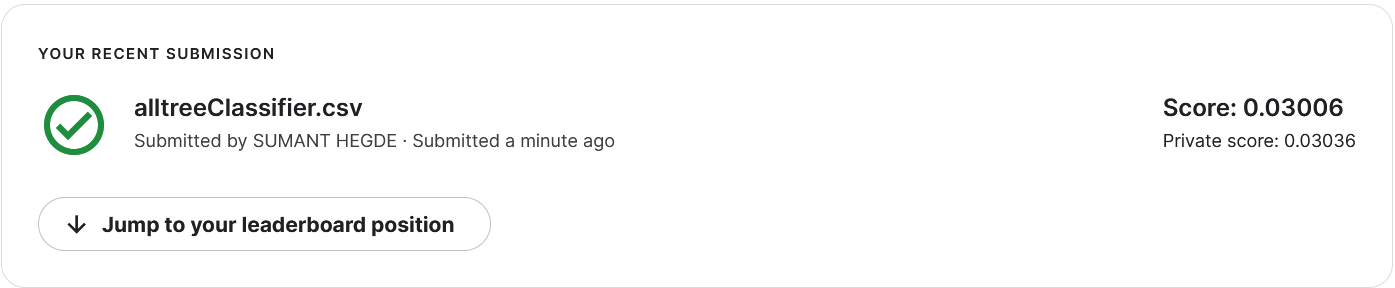

In [ ]:
table.add_row(['All tree classifiers', 'User features and Purchase Lags', '139', '0.03036'])

In [ ]:
trainmonths = [5,6,7,8,9,10,11,12,13,14,15] #months of data to be trained on 
lag_months = 5 #Number of lag months to be used
test_month = 16 #validation month (May 2016)

print('Processing the data...')
processed_training_data = data_processing(train_data_loc, test_data_loc, trainmonths, lag_months, test_month)
x_var, y_var, y_var_valid, x_var_test, test_prev_target, test_id, doc = processed_training_data


def objective(trial, x_varb = x_var, x_var_testb = x_var_test, y_var = y_var, y_var_valid = y_var_valid):
    '''
    This is an objective function for optuna for hyper parameter tuning
    This takes trial (an optuna object) and training and validation data

    returns score for the perticular combination of hyper parameters 
    '''
    param = {
        'iterations': trial.suggest_int('iterations', 500, 2500, 100),
        'learning_rate' : trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
        'depth' : trial.suggest_int('depth', 2, 8, 1),
        'l2_leaf_reg' : trial.suggest_loguniform('l2_leaf_reg', 1e-4, 1e4),
        'min_data_in_leaf' : trial.suggest_int('min_data_in_leaf', 5, 30, 5),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli","Poisson"]
        ),
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cb = CatBoostClassifier(**param, random_state=12, verbose=0, task_type = 'GPU')
    cb.fit(x_varb, y_var) #training the model for a set of hyperparameter values

    validpred = cb.predict(x_var_testb) #predicting the validation data
    score = precision_score(y_var_valid, validpred, average='micro') #getting the metric
    return score

study = optuna.create_study(direction='maximize') #creating a optuna study
study.optimize(objective, n_trials=40) #optimizing the study for objective

Processing the data...


11184636it [13:30, 13974.04it/s]

In [ ]:
cb = CatBoostClassifier(**study.best_trial.params, random_state=12, verbose=0, task_type = 'GPU')
cb.fit(x_var, y_var) #training the model with best hyperparameters

validpred = cb.predict(x_var_test) #getting validation prediction
print(precision_score(y_var_valid, validpred, average='micro'))

0.6593386292259376


In [ ]:
params = {'bootstrap_type': 'Bernoulli', #Best trial hyperparameters
           'depth': 6, 
           'iterations': 1700, 
           'l2_leaf_reg': 4.181252043113607, 
           'learning_rate': 0.06040838469698264, 
           'min_data_in_leaf': 25, 
           'subsample': 0.8849619669008696}

trainmonths = [5,6,7,8,9,10,11,12,13,14,15,16] #months of data to be trained on 
lag_months = 5 #Number of lag months to be used
test_month = 17 #testing month (June 2016)

print('Processing the data...')
processed_data = data_processing(train_data_loc, test_data_loc, trainmonths, lag_months, test_month)
x_var, y_var, y_var_valid, x_var_test, test_prev_target, test_id, doc = processed_data

print('train data shape', x_var.shape)
print('test data shape', x_var_test.shape)
train_y = np.array(y_var)
y_set = set(train_y)

print('training the catboost model...')
t = time()
cb = CatBoostClassifier(**params, task_type = 'GPU', silent=True)
cb.fit(x_var, y_var)
print('time taken to train the model', time()-t)

print('making the predictions...')
t = time()
catpred = cb.predict_proba(x_var_test)
print('time taken to predict', time()-t)

print('Getting the recommendations')
recommendations = get_top_products(test_id, pred, test_prev_target, y_set)
recommendations = productids_names(recommendations, target_cols)
get_recomendations(recommendations, test_data_loc, 'CatBoostClassifier.csv')
!kaggle competitions submit -c santander-product-recommendation -f /content/CatBoostClassifier.csv -m "CatBoostClassifier"

train data shape (531717, 139)
test data shape (929615, 139)
training the catboost model...
time taken to train the model 50.865819454193115
making the predictions...
time taken to predict 10.342930793762207
Getting the recommendations


929615it [00:09, 98448.71it/s] 


Converting product ids to names
CatBoostClassifier.csv is created
100% 115M/115M [00:05<00:00, 20.2MB/s]
Successfully submitted to Santander Product Recommendation

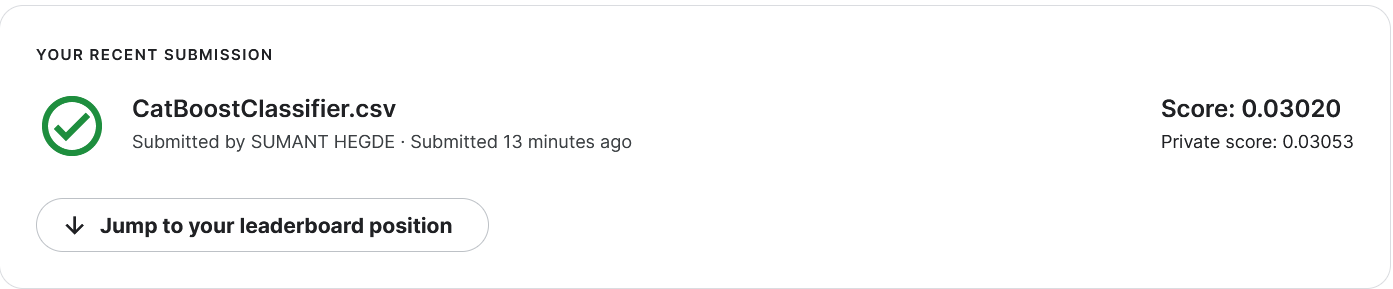

In [ ]:
table.add_row(['Catboost Calssifier', 'User features and Purchase Lags', '139', '0.03053'])

Adding more features that catch past trends of purchase

features:
* product exists atleast once in the lag months
* product exists all the months(last 5 months)
* product removed in the lag months
* product added in the lag months
* product removed recently(removed this current month)
* product added recently(added this current month)

In [ ]:
def data_processing(data_loc, test_data_loc, trainmonths, lag_months, test_month):
  '''
  This function takes training and test data locations, Months to train on, lag months and the testing month

  returns the preprocessed train and test data in csr matrix form 

  data_loc : training data location 
  test_data_loc : test data location 
  trainmonths : Months to be trained on
  lag_months : Number of lag months
  test_month : Months to be tested on
  '''

  prev_target = {} #This holds the previous target of each user
  first_train_month = min(trainmonths) #This is the first month among the training months
  row_count, row_count_valid, row_count_test = 0, 0, 0 #Initializing the row counts
  matrix_row, matrix_col, matrix_data = [], [], [] #Initializing the train matrix
  matrix_row_valid, matrix_col_valid, matrix_data_valid = [], [], [] #Initializing the validation matrix
  matrix_row_test, matrix_col_test, matrix_data_test = [], [], [] #Initializing the test matrix
  y_var, y_var_valid = [],[] #initializing target variable of train and validation data
  previous_purchase_month = {} #This holds the month of previous purchase of each user
  test_prev_target = [] #This holds all the products each user holds at the end of training months
  test_id = [] #This holds the ids of test data
  lag = {} #This holds the purchase lag of each user each month
  doc = {} #This holds each category of each categorical feature and a unique int associated with it
  for col in cat_columns:
      doc[col] = {} #Initializing document for all the categorical columns
  
 
  data_file = open(data_loc) #opening the training file
  for row in tqdm(csv.DictReader(data_file)): #Reading the file
    if month_dict[row['fecha_dato']] == test_month:
      train = False #if its testing month keep train variable false
    else:
      train = True #if its training month keep train variable true

    if month_dict[row['fecha_dato']] >= first_train_month - lag_months: #If the month is in lag months of any training month
      y = [] #initializaing target variable for a row
      for col in target_cols: #processing the target cols (few target cols have str data)
        c = row[col]
        if c and c != 'NA':
          y.append(int(c))
        else:
          y.append(0)
      y = np.array(y)
      target = (y - prev_target.get(int(row['ncodpers']), np.zeros(24))) > 0 #target = product held this month - products held last month

      if target.sum() > 0: #if the customer has bought new product in the current month
        if month_dict[row['fecha_dato']] in trainmonths + [test_month]: #if the month in either training month or testing month
          col_count = 0 #initializing column count to zero
          
          row_cols = [] #initializing list to hold column numbers of current row
          row_values = [] #initializing list to hold values of columns of current row
          
          for col in num_columns: #for each numerical column
            v = process_num_columns(row[col]) #processing num columns
            if v != 0: #if value of col is non zero
              row_cols.append(col_count) #appending column number
              row_values.append(v) #appending col value
            col_count += 1 #moving to next column
          
          for col in cat_columns: #for each categorical column
            v = process_cat_columns(row[col], col, train, doc) #processing categorical columns
            if v != 0: #if value of col is non zero
              row_cols.append(col_count) #appending column number
              row_values.append(v) #appending col value
            col_count += 1 #moving to next column
          
          row_values.append(month_dict[row['fecha_dato']] % 12) #current month
          row_cols.append(col_count) #appending column number
          col_count += 1 #moving to next column

          row_values.append(month_dict[row['fecha_dato']] - previous_purchase_month.get(int(row['ncodpers']), 0)) #number months since last purchase
          row_cols.append(col_count) #appending column number
          col_count += 1 #moving to next column

          lag_columns = [] #initializing lag columns
          lag_values = []
          for i in range(1,lag_months+1): #for each lag month
            k = months[month_dict[row['fecha_dato']] - i] #lag month
            lg =  lag.get((int(row['ncodpers']), k), np.zeros(24)) #get the products held in lag month
            lag_columns += list(np.argwhere((lg)>0)[:,0]+ (i-1)*24 + col_count) #list products held in lag month
            lag_values.append(lg)

          lag_values = np.array(lag_values) #converting lag values into arrays
          col_count += lag_months*24 #increasing column count 

          row_cols += lag_columns #appending column numbers of lag columns
          row_values += [1]*len(lag_columns) #appending 1 for each lag column

          #Get products present in any of the past lags
          present_in_any_past_lag = list(np.argwhere((np.array(lag_values).sum(axis=0))>0)[:,0] + col_count)
          row_cols += present_in_any_past_lag #appending column numbers of lag columns
          row_values += [1]*len(present_in_any_past_lag) #appending 1 for each lag column
          col_count += 24
          
          #Get products present in all the past lags
          present_in_all_past_lag = list(np.argwhere((np.array(lag_values).sum(axis=0))==lag_months)[:,0] + col_count)
          row_cols += present_in_all_past_lag #appending column numbers of lag columns
          row_values += [1]*len(present_in_all_past_lag) #appending 1 for each lag column
          col_count += 24

          #Get products removed in any of the past lags
          removed_in_lag_months = list(np.argwhere(((lag_values[1:,:] - lag_values[:-1,:]) < 0).sum(axis=0)>0)[:,0] + col_count)
          row_cols += removed_in_lag_months #appending column numbers of lag columns
          row_values += [1]*len(removed_in_lag_months) #appending 1 for each lag column
          col_count += 24

          #Get products added in any of the past lags
          added_in_lag_months = list(np.argwhere(((lag_values[1:,:] - lag_values[:-1,:]) > 0).sum(axis=0)>0)[:,0] + col_count)
          row_cols += added_in_lag_months #appending column numbers of lag columns
          row_values += [1]*len(added_in_lag_months) #appending 1 for each lag column
          col_count += 24

          #Get products removed in last month
          removed_last_month = list(np.argwhere((lag_values[-1] - lag_values[-2]) <0)[:,0] + col_count)
          row_cols += removed_last_month #appending column numbers of lag columns
          row_values += [1]*len(removed_last_month) #appending 1 for each lag column
          col_count += 24

          #Get products added in last month
          added_last_month = list(np.argwhere((lag_values[-1] - lag_values[-2]) >0)[:,0] + col_count)
          row_cols += added_last_month #appending column numbers of lag columns
          row_values += [1]*len(added_last_month) #appending 1 for each lag column
          col_count += 24


          if train == True: #if its one of training month
            for ind, prod in enumerate(np.argwhere((target)>0)[:,0]): #columns where new product is purchased
              matrix_col += row_cols #appending all the columns numbers
              matrix_data += row_values #appending all the column values
              matrix_row += [row_count]*len(row_cols) #appending row counts
              y_var.append(prod) #appending target column
              row_count+=1 #increasing row count
          else: #if its one of validation month
            for ind, prod in enumerate(np.argwhere((target)>0)[:,0]): #columns where new product is purchased
              matrix_col_valid += row_cols #appending all the columns numbers
              matrix_data_valid += row_values #appending all the column values
              matrix_row_valid += [row_count_valid]*len(row_cols) #appending row counts
              y_var_valid.append(prod) #appending target column
              row_count_valid+=1 #increasing row count

      if target.sum() > 0: #if the customer has bought new product in the current month
        previous_purchase_month[int(row['ncodpers'])] = month_dict[row['fecha_dato']] #updating previous purchase month 
      prev_target[int(row['ncodpers'])] = list(y) #updating previous target
      lag[(int(row['ncodpers']), row['fecha_dato'])] = y #updating lag

  x_var = csr_matrix((matrix_data, (matrix_row,matrix_col))) #convering lists to csr matrix
  if test_month != 17: #if the test month is not june 2016
    x_var_test = csr_matrix((matrix_data_valid, (matrix_row_valid, matrix_col_valid))) #convering lists to csr matrix
  
  del matrix_data, matrix_row, matrix_col, matrix_data_valid, matrix_row_valid, matrix_col_valid #deleting lists from memory

  if test_month == 17: #if the test month is june 2016
    test_data_file = open(test_data_loc) #opening the testing file
    for row in tqdm(csv.DictReader(test_data_file)): #Reading the file

      test_id.append(int(row['ncodpers'])) #appending the customer id 
      col_count = 0 #initializing column count
      row_cols = [] #initializing list to hold column numbers of current row
      row_values = [] #initializing list to hold values of columns of current row

      for col in num_columns: #for each numerical column
        v = process_num_columns(row[col]) #processing num columns
        if v != 0: #if value of col is non zero
          row_cols.append(col_count) #appending column number
          row_values.append(v) #appending col value
        col_count += 1 #moving to next column
      
      for col in cat_columns: #for each categorical column
        v = process_cat_columns(row[col], col, False, doc) #processing categorical columns
        if v != 0: #if value of col is non zero
          row_cols.append(col_count) #appending column number
          row_values.append(v) #appending col value
        col_count += 1 #moving to next column

      row_values.append(month_dict[row['fecha_dato']] % 12) #current month
      row_cols.append(col_count) #appending column number
      col_count += 1 #moving to next column

      row_values.append(month_dict[row['fecha_dato']] - previous_purchase_month.get(int(row['ncodpers']), 0)) #number months since last purchase
      row_cols.append(col_count) #appending column number
      col_count += 1 #moving to next column

      lag_columns = [] #initializing lag columns
      lag_values = []
      for i in range(1,lag_months+1): #for each lag month
        k = months[month_dict[row['fecha_dato']] - i] #lag month
        lg =  lag.get((int(row['ncodpers']), k), np.zeros(24)) #get the products held in lag month
        lag_columns += list(np.argwhere((lg)>0)[:,0]+ (i-1)*24 + col_count) #list products held in lag month
        lag_values.append(lg)

      lag_values = np.array(lag_values)
      col_count += lag_months*24

      row_cols += lag_columns #appending column numbers of lag columns
      row_values += [1]*len(lag_columns) #appending 1 for each lag column

      #Get products present in any of the past lags
      present_in_any_past_lag = list(np.argwhere((np.array(lag_values).sum(axis=0))>0)[:,0] + col_count)
      row_cols += present_in_any_past_lag #appending column numbers of lag columns
      row_values += [1]*len(present_in_any_past_lag) #appending 1 for each lag column
      col_count += 24

      #Get products present in all of the past lags
      present_in_all_past_lag = list(np.argwhere((np.array(lag_values).sum(axis=0))==lag_months)[:,0] + col_count)
      row_cols += present_in_all_past_lag #appending column numbers of lag columns
      row_values += [1]*len(present_in_all_past_lag) #appending 1 for each lag column
      col_count += 24

      #Get products removed in any of the past lags
      removed_in_lag_months = list(np.argwhere(((lag_values[1:,:] - lag_values[:-1,:]) < 0).sum(axis=0)>0)[:,0] + col_count)
      row_cols += removed_in_lag_months #appending column numbers of lag columns
      row_values += [1]*len(removed_in_lag_months) #appending 1 for each lag column
      col_count += 24

      #Get products added in any of the past lags
      added_in_lag_months = list(np.argwhere(((lag_values[1:,:] - lag_values[:-1,:]) > 0).sum(axis=0)>0)[:,0] + col_count)
      row_cols += added_in_lag_months #appending column numbers of lag columns
      row_values += [1]*len(added_in_lag_months) #appending 1 for each lag column
      col_count += 24

      #Get products removed in last month
      removed_last_month = list(np.argwhere((lag_values[-1] - lag_values[-2]) <0)[:,0] + col_count)
      row_cols += removed_last_month #appending column numbers of lag columns
      row_values += [1]*len(removed_last_month) #appending 1 for each lag column
      col_count += 24

      #Get products removed in last month
      added_last_month = list(np.argwhere((lag_values[-1] - lag_values[-2]) >0)[:,0] + col_count)
      row_cols += added_last_month #appending column numbers of lag columns
      row_values += [1]*len(added_last_month) #appending 1 for each lag column
      
      matrix_col_test += row_cols #appending all the columns numbers
      matrix_data_test += row_values #appending all the columns values
      matrix_row_test += [row_count_test]*len(row_cols) #appending row counts
      row_count_test+=1 #increasing row count
      test_prev_target.append(prev_target.get(int(row['ncodpers']),np.zeros(24))) #getting the previously purchased products

    x_var_test = csr_matrix((matrix_data_test, (matrix_row_test, matrix_col_test))) #convering lists to csr matrix

  del matrix_data_test, matrix_row_test, matrix_col_test #deleting lists from memory

  return x_var, y_var, y_var_valid, x_var_test, test_prev_target, test_id

In [ ]:
#These hyperparameters were found using optuna 
params = {'iterations': 1200,
 'learning_rate': 0.04689632626455222,
 'depth': 7,
 'l2_leaf_reg': 0.018426739391771783,
 'min_data_in_leaf': 30,
 'bootstrap_type': 'Poisson'}


trainmonths = [5,6,7,8,9,10,11,12,13,14,15,16] #months of data to be trained on 
lag_months = 5 #Number of lag months to be used
test_month = 17 #testing month (June 2016)

print('Processing the data...')
processed_data = data_processing(train_data_loc, test_data_loc, trainmonths, lag_months, test_month)
x_var, y_var, y_var_valid, x_var_test, test_prev_target, test_id, doc = processed_data

print('train data shape', x_var.shape)
print('test data shape', x_var_test.shape)
train_y = np.array(y_var)
y_set = set(train_y)

print('training the catboost model...')
t = time()
cb = CatBoostClassifier(**params, task_type = 'GPU', silent=True)
cb.fit(x_var, y_var)
print('time taken to train the model', time()-t)

print('making the predictions...')
t = time()
extendedpred = cb.predict_proba(x_var_test)
print('time taken to predict', time()-t)

print('Getting the recommendations')
recommendations = get_top_products(test_id, extendedpred, test_prev_target, y_set)
recommendations = productids_names(recommendations, target_cols)
get_recomendations(recommendations, test_data_loc, 'CatBoostClassifier.csv')
!kaggle competitions submit -c santander-product-recommendation -f /content/CatBoostClassifier.csv -m "CatBoostClassifier"

train data shape (531717, 283)
test data shape (929615, 283)
training the catboost model...
time taken to train the model 43.90034794807434
making the predictions...
time taken to predict 9.020130157470703
Getting the recommendations


929615it [00:08, 105735.85it/s]


Converting product ids to names
CatBoostClassifier.csv is created
100% 115M/115M [00:06<00:00, 17.9MB/s]
Successfully submitted to Santander Product Recommendation

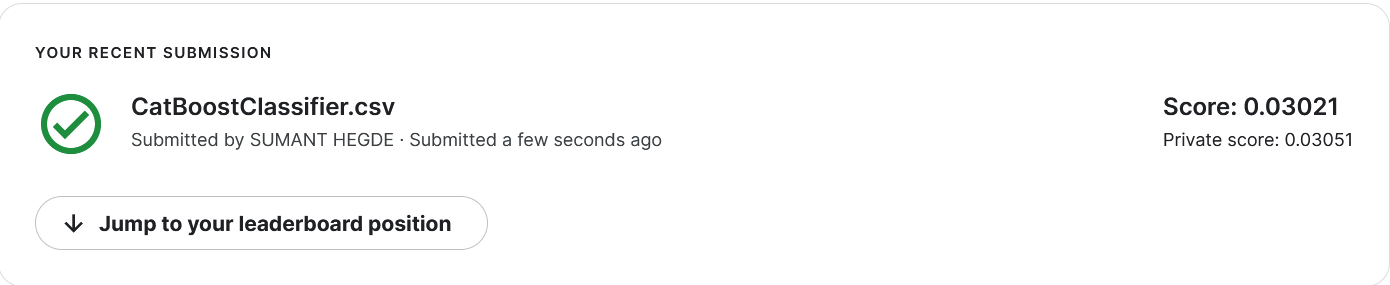

In [ ]:
table.add_row(['Catboost Calssifier', 'User features, Purchase Lags, Purchse behaviours', '283', '0.03051'])

Aggregating top performing model outputs

In [ ]:
pred = catpred + extendedpred
print('Getting the recommendations')
recommendations = get_top_products(test_id, pred, test_prev_target, y_set)
recommendations = productids_names(recommendations, target_cols)
get_recomendations(recommendations, test_data_loc, 'CatBoostClassifier.csv')
!kaggle competitions submit -c santander-product-recommendation -f /content/CatBoostClassifier.csv -m "CatBoostClassifier"

Getting the recommendations


929615it [00:09, 94673.40it/s] 


Converting product ids to names
CatBoostClassifier.csv is created
100% 115M/115M [00:06<00:00, 18.8MB/s]
Successfully submitted to Santander Product Recommendation

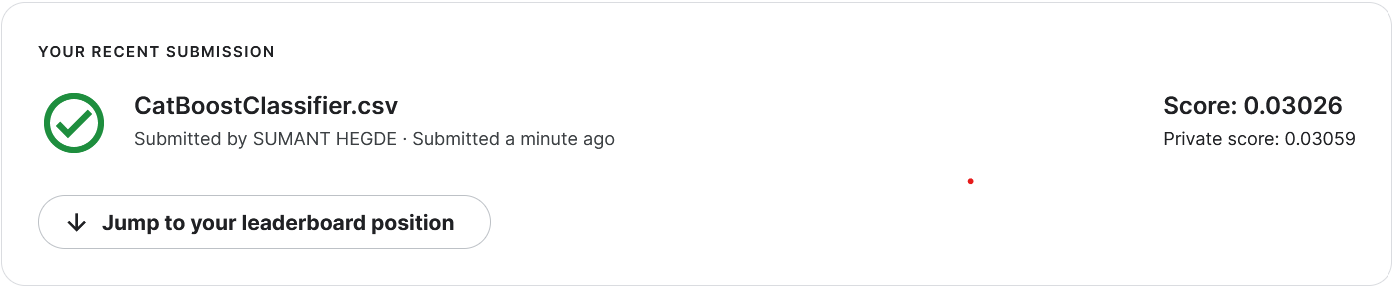

In [ ]:
table.add_row(['Catboost Calssifier Aggregation', 'User features, Purchase Lags, Purchse behaviours', '139-283', '0.03059'])

In [ ]:
trainmonths = [5,6,7,8,9,10,11,12,13,14,15] #months of data to be trained on 
lag_months = 5 #Number of lag months to be used
test_month = 16 #validation month (May 2016)

print('Processing the data...')
processed_training_data = data_processing(train_data_loc, test_data_loc, trainmonths, lag_months, test_month)
x_var, y_var, y_var_valid, x_var_test, test_prev_target, test_id, doc = processed_training_data

In [ ]:
params = {'bootstrap_type': 'Bernoulli', #Best trial hyperparameters
           'depth': 6, 
           'iterations': 1700, 
           'l2_leaf_reg': 4.181252043113607, 
           'learning_rate': 0.06040838469698264, 
           'min_data_in_leaf': 25, 
           'subsample': 0.8849619669008696}

print('train data shape', x_var[:,:139].shape)
print('test data shape', x_var_test[:,:139].shape)
train_y = np.array(y_var)
y_set = set(train_y)

print('training the catboost model...')
t = time()
cb = CatBoostClassifier(**params, task_type = 'GPU', silent=True)
cb.fit(x_var[:,:139], y_var)
print('time taken to train the model', time()-t)

print('making the predictions...')
t = time()
catpred = cb.predict_proba(x_var_test[:,:139])
print('time taken to predict', time()-t)



#These hyperparameters were found using optuna 
params = {'iterations': 1200,
 'learning_rate': 0.04689632626455222,
 'depth': 7,
 'l2_leaf_reg': 0.018426739391771783,
 'min_data_in_leaf': 30,
 'bootstrap_type': 'Poisson'}


print('train data shape', x_var.shape)
print('test data shape', x_var_test.shape)
train_y = np.array(y_var)
y_set = set(train_y)

print('training the catboost model...')
t = time()
cb = CatBoostClassifier(**params, task_type = 'GPU', silent=True)
cb.fit(x_var, y_var)
print('time taken to train the model', time()-t)

print('making the predictions...')
t = time()
extendedpred = cb.predict_proba(x_var_test)
print('time taken to predict', time()-t)

pred = catpred + extendedpred
y_pred = np.argmax(pred, axis=1)+1

train data shape (493826, 139)
test data shape (37891, 139)
training the catboost model...
time taken to train the model 46.690534830093384
making the predictions...
time taken to predict 0.5370161533355713
train data shape (493826, 283)
test data shape (37891, 283)
training the catboost model...
time taken to train the model 40.611217737197876
making the predictions...
time taken to predict 0.42830348014831543


Plotting precision matrix

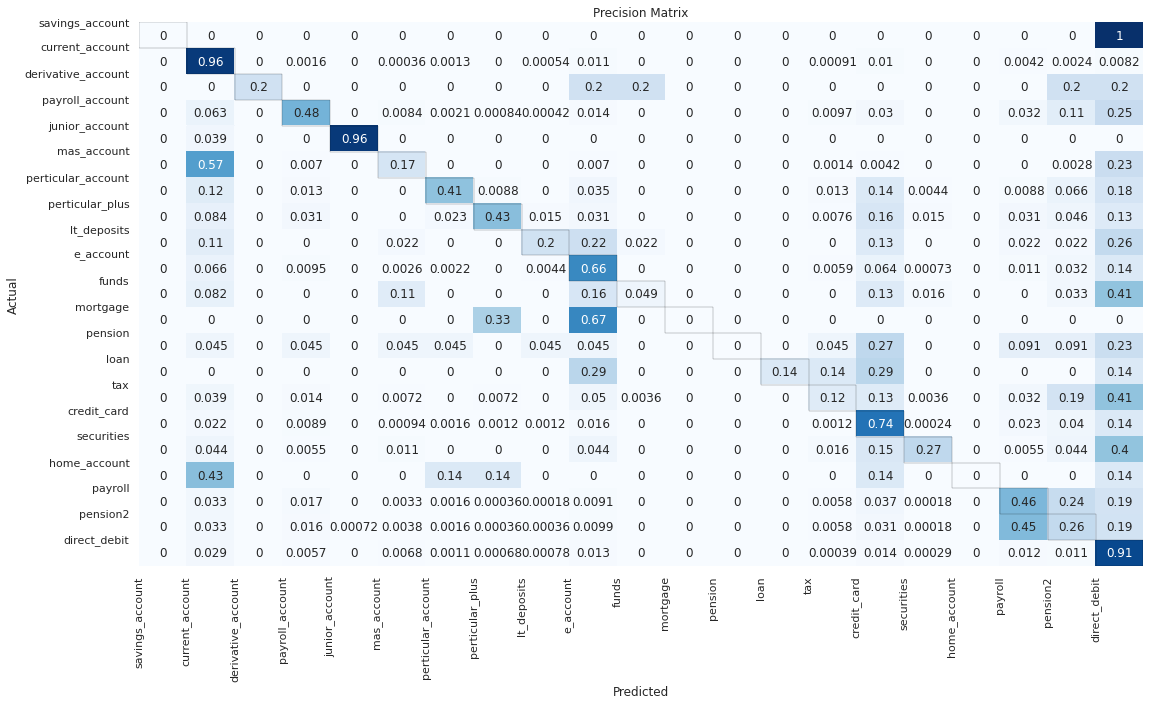

In [ ]:
plt.figure(figsize=(18,10))
cfm = confusion_matrix(y_var_valid, y_pred, normalize='true')
g = sn.heatmap(cfm, annot = True, cbar=False, cmap='Blues')

for i in range(len(set(y_var_valid))):
  g.add_patch(Rectangle((i, i), 1, 1, fill=False, edgecolor='black', lw=0.2))

plt.xticks(np.arange(len(set(y_var_valid))),np.array(target_columns)[list(set(y_var_valid))])
plt.xticks(rotation = 90)

plt.yticks(np.arange(len(set(y_var_valid))),np.array(target_columns)[list(set(y_var_valid))])
plt.yticks(rotation = 0)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Precision Matrix')
plt.show()

Observations:
* We can see none of the savings accounnts or derivative accounts are classified correctly
* Most of the current account, juniour account, direct debit are classified corrrectly
* 57% of mas account is classified as current account and 43% home account is classified as current account
* Mortgage accounts are either classified as e account or perticular account
* Home accounts are either classified as current account, perticular account, credit card or direct debit accounts
* None of the pension accounts are classified correctly

Plotting recall matrix

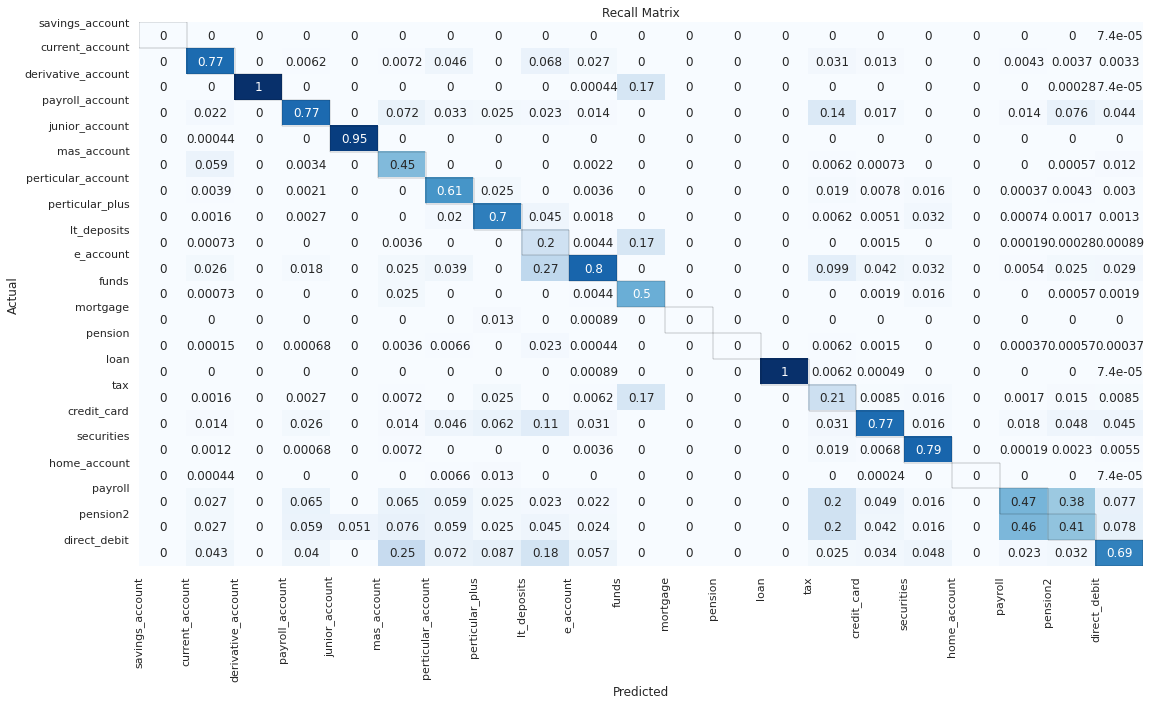

In [ ]:
plt.figure(figsize=(18,10))
cfm = confusion_matrix(y_var_valid, y_pred, normalize='pred')
g = sn.heatmap(cfm, annot = True, cbar=False, cmap='Blues')

for i in range(len(set(y_var_valid))):
  g.add_patch(Rectangle((i, i), 1, 1, fill=False, edgecolor='black', lw=0.2))

plt.xticks(np.arange(len(set(y_var_valid))),np.array(target_columns)[list(set(y_var_valid))])
plt.xticks(rotation = 90)

plt.yticks(np.arange(len(set(y_var_valid))),np.array(target_columns)[list(set(y_var_valid))])
plt.yticks(rotation = 0)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Recall Matrix')
plt.show()

Observations:
* 100% of predicted loan accounts and 95% of predicted juniour accounts are correct
* Only 20% of predicted long term deposits are correct but 27% of the predicted long term deposits are actually e_accounts
* Model didnt classify any data points to savings account, morgage, pension or to Home account
* Most of the data points classified as tax are more likely be payroll or pension2 accounts
* Interestingly only 69% of predicted direct debit is actually direct debit

In [ ]:
#getting the names of the features
lag_features = [] 
for i in range(1,lag_months+1):
  for c in target_columns:
    lag_features.append(c+'lag'+str(i))

extendedfeatures = ['_presentinpast','_presentinallpast','_removedinpast','_addedinpast','_removedlastmonth','_addedlastmonth']
for f in extendedfeatures:
  for c in target_columns:
    lag_features.append(c+f)
feature_names = np.array(num_columns + cat_columns + ['month', 'last_purchase'] + lag_features)

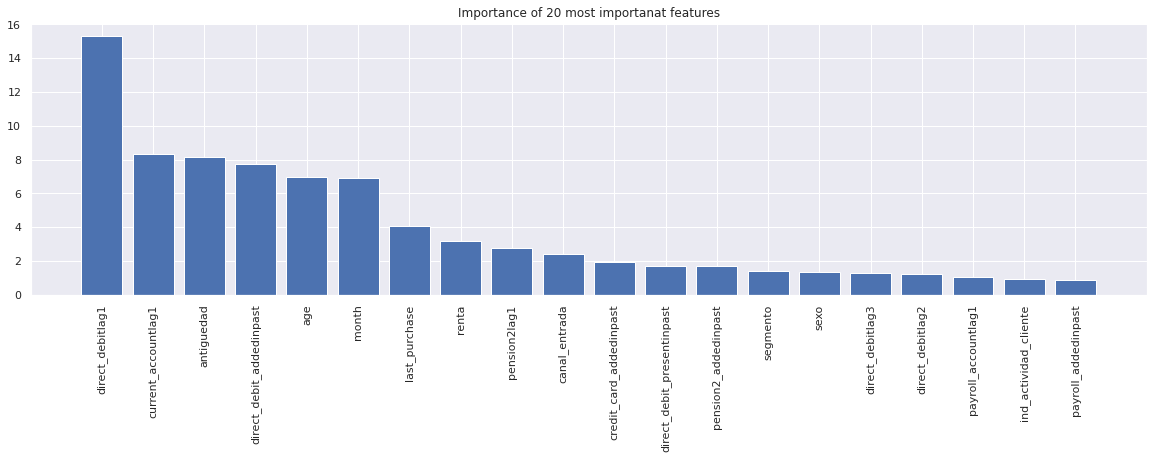

In [ ]:
#Plotting feature importance of the best catboost model
plt.figure(figsize=(20,5))
plt.bar(range(20), np.sort(cb.get_feature_importance())[::-1][:20])
plt.title('Importance of 20 most importanat features')
plt.xticks(np.arange(20),list(feature_names[np.argsort(cb.get_feature_importance())[::-1]][:20]), rotation = 90)
plt.show()

Observations:
* Top fatures list is majorly made of lag features and extended features
* antiguedad (cust_seniority) is the most important non lag feature, age, month follow that
* first lag of ind_receibo_ult1 (direct_debit) is the most important feature with around 14.5% of feature importance

In [ ]:
#Plotting hyperparameter importance
optuna.visualization.plot_param_importances(study)

Observations:
* learning rate is the most important hyperparameter. Depth, l2_leaf_reg and other hyperparameters follow that.

Based on the observation from the above recall matrix let's change all the prediction of long term account to e account 

In [ ]:
params = {'bootstrap_type': 'Bernoulli', #Best trial hyperparameters
           'depth': 6, 
           'iterations': 1700, 
           'l2_leaf_reg': 4.181252043113607, 
           'learning_rate': 0.06040838469698264, 
           'min_data_in_leaf': 25, 
           'subsample': 0.8849619669008696}
x_var, y_var, y_var_valid, x_var_test, test_prev_target, test_id, doc = processed_data

print('train data shape', x_var.shape)
print('test data shape', x_var_test.shape)
train_y = np.array(y_var)
y_set = set(train_y)

print('training the catboost model...')
t = time()
cb = CatBoostClassifier(**params, task_type = 'GPU', silent=True)
cb.fit(x_var, y_var)
print('time taken to train the model', time()-t)

print('making the predictions...')
t = time()
catpred = cb.predict_proba(x_var_test)
print('time taken to predict', time()-t)

#These hyperparameters were found using optuna 
params = {'iterations': 1200,
 'learning_rate': 0.04689632626455222,
 'depth': 7,
 'l2_leaf_reg': 0.018426739391771783,
 'min_data_in_leaf': 30,
 'bootstrap_type': 'Poisson'}

x_var, y_var, y_var_valid, x_var_test, test_prev_target, test_id, doc = processed_data

print('train data shape', x_var.shape)
print('test data shape', x_var_test.shape)
train_y = np.array(y_var)
y_set = set(train_y)

print('training the catboost model...')
t = time()
cb = CatBoostClassifier(**params, task_type = 'GPU', silent=True)
cb.fit(x_var, y_var)
print('time taken to train the model', time()-t)

print('making the predictions...')
t = time()
extendedpred = cb.predict_proba(x_var_test)
print('time taken to predict', time()-t)

train data shape (531717, 283)
test data shape (929615, 283)
training the catboost model...
time taken to train the model 52.808799028396606
making the predictions...
time taken to predict 10.660760164260864


In [ ]:
pred = catpred + extendedpred
print('Getting the recommendations')
recommendations = get_top_products(test_id, pred, test_prev_target, y_set)
recommendations[recommendations == 11] = 12
recommendations = productids_names(recommendations, target_cols)
get_recomendations(recommendations, test_data_loc, 'CatBoostClassifier.csv')
!kaggle competitions submit -c santander-product-recommendation -f /content/CatBoostClassifier.csv -m "CatBoostClassifier"

Getting the recommendations


929615it [00:09, 102299.72it/s]


Converting product ids to names
CatBoostClassifier.csv is created
100% 115M/115M [00:07<00:00, 15.7MB/s]
Successfully submitted to Santander Product Recommendation

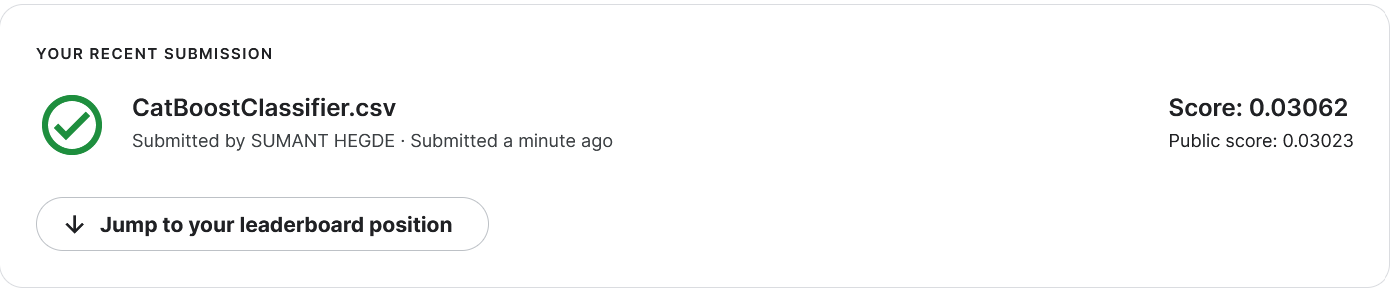

In [ ]:
table.add_row(['Catboost Calssifier Aggregation + Post processing', 'User features, Purchase Lags, Purchse behaviours', '139-283', '0.03062'])

Finaly if I had participated in the competition and used all these methods, my rank would have been 61/1779 (under top 3.5%) and a Silver Medel :)

Summerizing all the models

In [ ]:
print(table)

+---------------------------------------------------+--------------------------------------------------+--------------------+---------+
|                       Model                       |                     features                     | number of features |  Score  |
+---------------------------------------------------+--------------------------------------------------+--------------------+---------+
|            baseline (Random Prediction)           |                                                  |                    | 0.00392 |
|         baselineII (Most famous products)         |               Past purchase count                |         24         | 0.01486 |
|                   categorical NB                  |              User features and Lags              |        164         | 0.01936 |
|                All tree classifiers               |         User features and Purchase Lags          |        139         | 0.03036 |
|                Catboost Calssifier            